<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/main/IDP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrinsically disordered proteins in thermophilic bacteria

In this notebook we go through IDR prediction of various protein datasets and compare the IDR content of these datasets.

https://omabrowser.org/oma/genomePW/

https://github.com/dessimozlab/pyham

In [ ]:
# !git init

# %cd /content/IDP_analysis/

# !git add .

# !git config --global user.email "alibek.kruglikov11@gmail.com"
# !git config --global user.name "alibekk93"

# !git commit -m "Message"

# !git push https://<token>@github.com/alibekk93/IDP_analysis.git

## Setup

[Biopython](https://biopython.org/) package is used to read .fasta files and work with sequences. Other packages are used to process the data, connect with API services to predict IDR, download results, etc.

In [1]:
# copy repo to get available datafiles

!git clone https://github.com/alibekk93/IDP_analysis.git

Cloning into 'IDP_analysis'...
remote: Enumerating objects: 491, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 491 (delta 30), reused 23 (delta 9), pack-reused 412
Receiving objects: 100% (491/491), 185.49 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (166/166), done.
Checking out files: 100% (47/47), done.


In [2]:
#@title # Do you already have the disorder scores?

#@markdown Many of the packages are only required if
#@markdown you have to calculate the disorder scores.
#@markdown If you already have the scores, you should
#@markdown tick the box below, it will save time.

scores_calculated = True #@param {type: 'boolean'}

if scores_calculated == False:
  # connecting with API
  import urllib.request
  import json

  # install chromium, its driver, and selenium, set options
  !apt update
  !apt install chromium-chromedriver
  !pip install selenium
  from selenium import webdriver
  from selenium.webdriver.common.keys import Keys
  from selenium.webdriver.common.by import By
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')

# Biopython
!pip install BIO
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import MuscleCommandline
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.SubsMat.MatrixInfo import blosum62
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils.ProtParamData import gravy_scales

# files uploading / downloading
from google.colab import files
import pickle
from io import StringIO

# statistics
!pip install --upgrade scipy
from scipy.stats import mannwhitneyu, chisquare, pearsonr, ttest_ind, ttest_rel, wilcoxon
from sklearn.preprocessing import MinMaxScaler

# other packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.contrib import tzip
tqdm.pandas()

# install muscle
!sudo apt-get update
!sudo apt-get install muscle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 4.3 MB/s 
     |████████████████████████████████| 2.3 MB 10.3 MB/s 


/usr/local/lib/python3.7/dist-packages/Bio/SubsMat/__init__.py:131: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  BiopythonDeprecationWarning,


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRe

## Functions

In [3]:
def read_fasta(fasta_file: str) -> pd.DataFrame:
  """Processes raw .fasta files

  Opens a .fasta file, parses the sequences and their IDs into a
  dataframe and returns the dataframe.

  Parameters
  ----------
  fasta_file : str
    the raw .fasta file directory.
  
  Returns
  -------
  pd.DataFrame
    a dataframe with ID, Sequence and Length columns.

  """

  # open the file
  handle = open(fasta_file, 'r')
  seq_list = list(SeqIO.parse(handle, 'fasta'))
  handle.close()

  # parse data into lists
  ids = [seq_record.id.split('|')[1] for seq_record in seq_list]
  seqs = [str(seq_record.seq) for seq_record in seq_list]
  lens = [len(seq) for seq in seqs]

  # save data into a dataframe
  df = pd.DataFrame({'ID':ids, 'Sequence':seqs, 'Length':lens})

  return df

In [4]:
def try_retrieve_url(url: str, filename: str):
  """A simple try / except pattern for urllib.request
  """

  try:
    return urllib.request.urlretrieve(url, filename)
  except:
    return np.nan

In [5]:
def calculate_iupred(proteinID_list: list, score_only: bool=True) -> list:
  """Calculate protein IDR profile using IUPred3 REST API

  Creates URL based on protein UniProt accession numbers
  (from a list). Each IDR profile is saved as a JSON file
  and put into a list. The JSON files are then unpacked,
  either all data or only IUPred3 score are saved.

  Parameters
  ----------
  proteinID_list : list
    a list of protein accessions for which to predict IDR
  score_only : bool (default=True)
    whether the return should only contain IUPRed3 score.
    Other data are AA sequence, and a binary disorder
    prediction.

  Returns
  -------
  list
    a list of either IUPred3 scores or of all data from
    each JSON as a dictionary.

  """

  # make a list of URLs
  iupredURL_list = ['http://iupred3.elte.hu/iupred3/' + proteinID + '.json' \
                    for proteinID in proteinID_list]

  # download JSON files
  print('Retrieving disorder values from server...')
  protein_files = [try_retrieve_url(iupredURL, proteinID  + '.json')\
                   for iupredURL, proteinID in zip(tqdm(iupredURL_list),\
                                                        proteinID_list)]
  
  # empty list for unpacked JSON data
  proteins = []
  
  # populate the empty list
  print('Unpacking json files...')
  for proteinID in tqdm(proteinID_list):
    try:
      with open('/content/{}.json'.format(proteinID), 'r') as f:
        d = json.load(f)
        # check if only scores need to be saved
        if score_only == True:
          d = d['iupred2']
    except:
      d = np.nan
    proteins.append(d)
  
  return proteins

In [6]:
def read_pickle_file(file_name: str):
  """A simple function to read pickle files

  Parameters
  ----------
  file_name : srt
    location of the pickle file
  
  Returns
  -------
  any format, but best with pd.DataFrames or lists
  
  """

  print(file_name + ' loading...')
  with open(file_name, 'rb') as f:
    result = pickle.load(f)
  print(file_name + ' loaded!')
  return result

In [7]:
def binary_disorder(disorder_list: list, threshold: float=0.5) -> list:
  """Returns a list of binary values for disordered
  residues given a threshold

  Parameters
  ----------
  disorder_list : list
    a list of disorder values
  threshold : float
    a binary threshold, 0.5 by default. Disorder score
    above the threshold means that the residue is
    considered to be disordered
  
  Returns
  -------
  list
    a list of binary values indicating whether the
    residue is disordered (1) or not (0)
  
  """

  return [1 if dis > threshold else 0 for dis in disorder_list]

In [8]:
def find_longest_binary_IDR(binary_disorder_list: list) -> int:
  """Finds the longest stretch of binary IDR for a
  given protein

  Parameters
  ----------
  binary_disorder_list : list
    a list of binary values indicating whether the
    residue is disordered (1) or not (0)
  
  Returns
  -------
  int
    a number of disordered residues in the longest
    IDR
  
  """

  # set max IDR length as zero
  max_IDR_len = 0

  # set current IDR length as zero
  current_IDR_len = 0
  # iterate though each residue
  for disorder in binary_disorder_list:
    if disorder == 1:
      # increase current IDR length if disordered
      current_IDR_len += 1
    else:
      # not part of IDR, save current length if max or continue
      if current_IDR_len > max_IDR_len:
        max_IDR_len = current_IDR_len
      current_IDR_len = 0

  return max_IDR_len

In [9]:
def get_pondr_calculations(protein_ID: str, sequence: str, return_df: bool=True):
  """Uses Selenium to scrape PONDR disorder
  calculations for a given protein

  Parameters
  ----------
  protein_ID : str
    protein ID or name. Required by PONDR,
    but has no effect on result
  sequence : str
    AA sequence of the protein
  return_df : bool
    whether return should be a DataFrame
    (True) or a tuple of lists (False). True
    by default
  
  Returns:
  --------
  DataFrame or tuple with lists

  """

  # set up web driver to get data from pondr.com
  wd = webdriver.Chrome(options=options)
  wd.get('http://www.pondr.com/')
  # set options and submit
  wd.find_element(By.NAME, 'ProteinName').send_keys(protein_ID)
  wd.find_element(By.NAME, 'Sequence').send_keys(sequence)
  wd.find_element(By.NAME, 'VL3').click()
  wd.find_element(By.NAME, 'VSL2').click()
  wd.find_element(By.NAME, 'wcwraw').click()
  wd.find_element(By.NAME, 'submit_result').click()
  # paste the raw results table to a DataFrame
  try:
    table = wd.find_elements(By.TAG_NAME, 'pre')[-1]
    table_text = table.text
    disorder_df = pd.read_csv(StringIO(table_text.replace('  ', ' ')), sep=' ')[['VLXT', 'VL3', 'VSL2']]
  except:
    disorder_df = pd.DataFrame(columns=['VLXT', 'VL3', 'VSL2'])
  if return_df == True:
    return disorder_df
  else:
    return [*disorder_df['VLXT']], [*disorder_df['VL3']], [*disorder_df['VSL2']]

In [10]:
def fix_neg_inf(df: pd.DataFrame, replacement=np.nan) -> pd.DataFrame:
  """Replaces -inf values in a given dataframe

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe with -inf to be replaced
  replacement
    The value to replace -inf with. Default
    is np.nan
  
  Returns:
  --------
  pd.DataFrame

  """

  df_new = df.copy()
  df_new[df.astype(float) < 0] = replacement
  return df_new

In [318]:
def align_seqs(seqs: list, ids: list, gap_ins_pen: float=-1.0,
               gap_ext_pen: float=-0.5):
  """Multiple sequence alignment using Muscle

  Parameters
  ----------
  seqs : list
    A list of sequences to be aligned (as str)
  ids : list
    A list of sequence IDs (as str)
  gap_ins_pen : float
    Gap insertion penalty for the alignment.
    -1.0 by default
  gap_ext_pen : float
    Gap extension penalty for the alignment.
    -0.5 by default
  
  Returns
  -------
  Alignment object

  """

  # create seq records
  records = [SeqRecord(Seq(seq), id) for seq, id in zip(seqs, ids)]
  # save records as fasta
  with open('unaligned.fas', 'w') as handle:
    SeqIO.write(records, handle, 'fasta')
  # align using muscle
  cline = MuscleCommandline(input='unaligned.fas', out='aligned.fas',
                            gapextend=gap_ext_pen, gapopen=gap_ins_pen,
                            seqtype='protein', )
  cline()
  # read the output file
  align = AlignIO.read('aligned.fas', 'fasta')
  return align

In [348]:
for n in tqdm(IDP_pairs.query('TT_disorder_binary_mean>=0.5 or EC_disorder_binary_mean>=0.5 or BS_disorder_binary_mean>=0.5 or PF_disorder_binary_mean>=0.5')[['TT_ID', 'EC_ID', 'BS_ID', 'PF_ID']].values):
  names = [*n]
  
  fig_name = ''.join([n + '-' for n in names])[:-1] + '.svg'

  labels = ['T. thermophilus', 'E. coli', 'B. subtilis', 'P. fumarii']

  disorder_values = [IDP_pairs.query('TT_ID=="{}"'.format(names[0])).TT_disorder_combined.iloc[0],
                    IDP_pairs.query('EC_ID=="{}"'.format(names[1])).EC_disorder_combined.iloc[0],
                    IDP_pairs.query('BS_ID=="{}"'.format(names[2])).BS_disorder_combined.iloc[0],
                    IDP_pairs.query('PF_ID=="{}"'.format(names[3])).PF_disorder_combined.iloc[0]]
  seqs = [IDP_pairs.query('TT_ID=="{}"'.format(names[0])).TT_Sequence.iloc[0],
          IDP_pairs.query('EC_ID=="{}"'.format(names[1])).EC_Sequence.iloc[0],
          IDP_pairs.query('BS_ID=="{}"'.format(names[2])).BS_Sequence.iloc[0],
          IDP_pairs.query('PF_ID=="{}"'.format(names[3])).PF_Sequence.iloc[0]]
  colors = ['red', 'green', 'blue', 'orange']

  plot_IDR_profile(disorder_values=disorder_values, seqs=seqs, labels=labels, colors=colors, names=names, mav=50, scale_mav=True,
                   gap_ins_pen=-1.0, gap_ext_pen=-0.5, savefig=False)

  0%|          | 0/7 [00:00<?, ?it/s]

0:-:0
1:M:0.56215428633613
2:I:0.580566474391752
3:I:0.5367503825998035
4:R:0.5535319731390994
5:G:0.5055606369159316
6:V:0.4785458476632865
7:E:0.45659542491506594
8:L:0.4381689336553055
9:I:0.4152630401673938
10:N:0.397698905508277
11:F:0.38001926788847673
12:L:0.37411682013565034
13:S:0.3615833331962112
14:H:0.35079549645702457
15:R:0.33605359724914774
16:-:0
17:H:0.3203794900413144
18:T:0.3042742680255426
19:R:0.2882189725538986
20:L:0.26314762013708004
21:E:0.2502851105429658
22:F:0.22970184411441524
23:-:0
24:-:0
25:-:0
26:-:0
27:-:0
28:-:0
29:D:0.2122764209020609
30:T:0.2046498587020432
31:G:0.20856396615039566
32:I:0.21150940358703096
33:V:0.2153837550725025
34:A:0.21908430652819577
35:I:0.22051934622295244
36:V:0.2318277531211319
37:G:0.24566304222128332
38:P:0.2493981412931136
39:N:0.25501150834221215
40:G:0.25611773765202944
41:A:0.2627928365531141
42:G:0.2575930523619758
43:K:0.245603763846359
44:S:0.23869598795028704
45:S:0.21814571614142692
46:I:0.18674699871028214
47:I:0

  0%|          | 0/7 [00:01<?, ?it/s]


424:E:0.7644859473942839
425:E:0.7704843725820845
426:V:0.7755500495774968
427:L:0.7810024518008835
428:K:0.787601151826306
429:A:0.8047362116420235
430:L:0.8222184087704919
431:E:0.8287392307143862
432:A:0.8288012399754503
433:L:0.8243160512874033
434:G:0.8178384332433565
435:A:0.8120392269110246
436:E:0.805692028804033
437:L:0.7965396543062317
438:L:0.7885014199728569
439:R:0.7803095456228846
440:L:0.7716359934755271
441:R:0.7651604280810872
442:A:0.7602265339562659
443:W:0.754520702245545
444:A:0.7499597407860856
445:E:0.7455812554966623
446:A:0.7445342799423582
447:W:0.7395645377996573
448:E:0.7290378671322155
449:-:0
450:A:0.7205365782793985
451:L:0.7142892671835306
452:R:0.7119658358027923
453:A:0.7114166459318397
454:K:0.7139598823380576
455:E:0.7158233597230348
456:A:0.7156404577612325
457:A:0.7160320074767494
458:L:0.7286898684733708
459:A:0.7406721133688849
460:E:0.7495150846634341
461:V:0.7521890149169281
462:G:0.7475594669739154
463:E:0.7309293015636691
464:A:0.71928194597

IndexError: ignored

In [330]:
test1 = SeqRecord(Seq('--AA---AAAAAA--'))
test2 = [.1, .2, .3, .4, .5, .6, .7, .8]

for i, r in enumerate(test1.seq):
  if r == '-':
    test2.insert(i, np.nan)

print(test2)

[nan, nan, 0.1, 0.2, nan, nan, nan, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, nan, nan]


In [346]:
def plot_IDR_profile(disorder_values: list, seqs: list, labels: list,
                     colors: list, names: list=None, mav: int=1,
                     scale_mav=False, gap_ins_pen: float=-1.0,
                     gap_ext_pen: float=-0.5, savefig=False):
  """Plots an aligned IDR profile for proteins given
  their disorders and sequences lists

  Parameters
  ----------
  disorder_values : list
    A list of disorder values to be plotted
  seqs : list
    A list of sequences to be aligned
  labels : list
    A list of labels for the plot legend
  names : list
    A list of titles to be plotted. Is not
    required, but makes plot better
  mav : int
    Moving average value. 1 by default,
    which plots original values
  scale_mav : bool
    Whether mav should be scaled based on
    protein length. If True, original mav
    value would be multiplied by
    len(protein) / 500. False by default
  gap_ins_pen : float
    Gap insertion penalty for the alignment.
    Default penalty is -1
  gap_ext_pen : float
    Gap extension penalty for the alignment.
    Default penalty is -0.5
  savefig : bool
    Whether the figure should be saved.
    False by default
  
  Returns:
  --------
  No return, makes a plot

  """

  # make the alignment
  aligned_disorders = []
  alignment = align_seqs(seqs, labels, gap_ins_pen=gap_ins_pen, gap_ext_pen=gap_ext_pen)
  for a, d in zip(alignment, disorder_values):
    seq_disorder_full = [*d.copy()]
    for i, residue in enumerate(a.seq):
      if residue == '-':
        seq_disorder_full.insert(i, 0)
      print(i, a.seq[i], seq_disorder_full[i], sep=':')
    print(len(a.seq), len(d), len(seq_disorder_full))
    seq_disorder_full = pd.Series(seq_disorder_full).interpolate().tolist()
    aligned_disorders.append(seq_disorder_full)
    '''
  # plot values
  fig, ax = plt.subplots(figsize=(15, 8))
  # check for title
  if names != None:
    title = ''.join([n + ' : ' for n in names])
    fig.suptitle(title, fontsize=20)
  # Scale mav if needed
  if scale_mav == True:
    mav = int(np.round(mav * len(aligned_disorders[0]) / 500))
  # plot
  ax.set_ylim(0, 1)
  ax.set_xlabel('Position in sequence', fontsize=18)
  ax.set_ylabel('Predicted disorder', fontsize=18)
  ys = [np.convolve(ad, np.ones(mav)/mav) for ad in aligned_disorders]
  x = np.arange(0, len(ys[0]))
  for i, y in enumerate(ys):
    # cut extra mav values
    cut = int(mav / 2)
    # plot the values
    ax.plot(y[cut:len(y)-cut+1], c=colors[i], label='$\\it{}$'.format(labels[i]))
  # ax.fill_between(x, y1, y2, where = y1 > y2, facecolor ='red', alpha = 0.3)
  # ax.fill_between(x, y1, y2, where = y2 > y1, facecolor ='green', alpha = 0.3)
  ax.legend(loc='upper left')
  ax.axhline(0.5, ls='--', c='black')
  # check if needs to be saved
  if savefig == True:
    if names == None:
      raise ValueError('Sequence names not provided')
    fig.savefig(title + '.svg')
    '''

In [ ]:
# def plot_IDR_profile(disorder_values: list, labels: list, names: list=None,
#                      mav: int=1, scale_mav=False, align=False, 
#                      seqs: list=None, gap_ins_pen: float=-1,
#                      gap_ext_pen: float=-0.5, savefig=False):
#   """Plots an IDR profile for proteins given
#   in list

#   Parameters
#   ----------
#   disorder_values : list
#     A list of disorder values to be plotted
#   labels : list
#     A list of labels for the plot legend
#   names : list
#     A list of titles to be plotted. Is not
#     required, but makes plot better
#   mav : int
#     Moving average value. 1 by default,
#     which plots original values
#   scale_mav : bool
#     Whether mav should be scaled based on
#     protein length. If True, original mav
#     value would be multiplied by
#     len(protein) / 500. False by default
#   align : bool
#     If True, will align the disorder values
#     based on sequences. False by default
#   seqs : list
#     A list of sequences to be aligned. Is
#     required if align = True. None by
#     default
#   gap_ins_pen : float
#     Gap insertion penalty for the alignment.
#     Default penalty is -1
#   gap_ext_pen : float
#     Gap extension penalty for the alignment.
#     Default penalty is -0.5
#   savefig : bool
#     Whether the figure should be saved.
#     False by default
  
#   Returns:
#   --------
#   No return, makes a plot

#   """

#   seq1_disorder_full = [*disorder_values[0]]
#   seq2_disorder_full = [*disorder_values[1]]

#   # check if alignment is required
#   if align == True:
#     # check that sequences are provided
#     if seqs == None:
#       raise ValueError('Sequences were not provided for the alignment')
#     # make AA alignment
#     seq1 = seqs[0]
#     seq2 = seqs[1]
#     alignment = pairwise2.align.localds(seq1, seq2, blosum62, gap_ins_pen, gap_ext_pen)
#     # align disorder values
#     for i, residue in enumerate(alignment[0].seqA):
#       if residue == '-':
#         try:
#           seq1_disorder_full.insert(i, seq1_disorder_full[i-1])
#         except: seq1_disorder_full.insert(i, np.nan)
#     for i, residue in enumerate(alignment[0].seqB):
#       if residue == '-':
#         try:
#           seq2_disorder_full.insert(i, seq2_disorder_full[i-1])
#         except: seq2_disorder_full.insert(i, np.nan)
#   # plot values
#   fig, ax = plt.subplots(figsize=(15, 8))
#   # check for title
#   if names != None:
#     fig.suptitle(names[0] + ' : ' + names[1], fontsize=20)
#   # Scale mav if needed
#   if scale_mav == True:
#     mav = int(np.round(mav * len(seq1_disorder_full) / 500))
#   # plot
#   ax.set_ylim(0, 1)
#   ax.set_xlabel('Position in sequence', fontsize=18)
#   ax.set_ylabel('Predicted disorder', fontsize=18)
#   y1 = np.convolve(seq1_disorder_full, np.ones(mav)/mav)
#   y2 = np.convolve(seq2_disorder_full, np.ones(mav)/mav)
#   x = np.arange(0, len(y1))
#   ax.plot(y1, c='red', label='$\\it{}$'.format(labels[0]))
#   ax.plot(y2, c='green', label='$\\it{}$'.format(labels[1]))
#   ax.fill_between(x, y1, y2, where = y1 > y2, facecolor ='red', alpha = 0.3)
#   ax.fill_between(x, y1, y2, where = y2 > y1, facecolor ='green', alpha = 0.3)
#   ax.legend(loc='upper left')
#   ax.axhline(0.5, ls='--', c='black')
#   # check if needs to be saved
#   if savefig == True:
#     if names == None:
#       raise ValueError('Sequence names not provided')
#     fig.savefig(names[0] + ' - ' + names[1] + '.png')

In [14]:
def get_charge_hydrophobicity(seq: str) -> tuple:
  """Calculates mean absolute charge and hydrophobicity
  
  Parameters
  ----------
  seq : str
    AA sequence to calculate values for
  
  Returns:
  --------
  tuple
    tuple with two float values:
    1) mean absolute charge
    2) mean hydrophobicity (scaled 0-1)

  """

  # calculate mean absolute charge
  prot_analysis = ProteinAnalysis(seq)
  mean_abs_charge = abs(prot_analysis.charge_at_pH(7)) / prot_analysis.length

  # get Kyle-Doolitle scale
  KyteDoolitle = gravy_scales.get('KyteDoolitle', -1)
  KyteDoolitle['X'] = 0
  KyteDoolitle['U'] = 0
  # normalize scale to 0-1 range
  scaler = MinMaxScaler()
  KD_norm = {k:v[0] for k, v in zip(KyteDoolitle.keys(), scaler.fit_transform(np.array([*KyteDoolitle.values()]).reshape(-1, 1)))}
  # calculate mean hydrophobicity
  hydrophobicity_sum = sum(KD_norm[aa] for aa in seq)
  mean_hydrophobicity = hydrophobicity_sum / prot_analysis.length
  
  return mean_abs_charge, mean_hydrophobicity

## Obtaining disorder predictions for *E. coli* and *T. thermophilus* proteins

We can start by importing the protein sequences

In [15]:
# read two .fasta files
EC_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/EscherichiaColiK12_allProteins.fasta')
TT_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/ThermusThermophilusHB8_allProteins.fasta')
BS_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/BacillusSubtilis168_allProteins.fasta')
PF_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/PyrolobusFumariiDSM11204_allProteins.fasta')

# filter out short sequences (under 20 AA)
# short sequences do not get processed by IDR predictors
EC_proteome = EC_proteome_fasta[EC_proteome_fasta.Length > 19]
TT_proteome = TT_proteome_fasta[TT_proteome_fasta.Length > 19]
BS_proteome = BS_proteome_fasta[BS_proteome_fasta.Length > 19]
PF_proteome = PF_proteome_fasta[PF_proteome_fasta.Length > 19]

IUPred3 REST API works great for almost all proteins, however there are a couple exceptions.

First, IUPred3 only can predict IDR for proteins that are at least 20 AA long. For that reason we will filter out short proteins from our databases.

A more unfortunate issue is that in some rare cases the REST API does not return a JSON file due to server error 500. This happened with two protein accessions from our *E. coli* database (out of more than 4,000 accessions) - P76335 and P77650. The API still can provide results in text format, but those data cannot be downloaded as easily as JSON. To solve the issue, we obtain the results for the two accessions manually and concatenate the manual results with the automatic results in the same order as the data were in the original dataframe.

PONDR has no REST API, so we will use [Selenium](https://selenium-python.readthedocs.io/) to scrape the results. The protein IDs and sequences will be passed into corresponding HTML forms and raw results will be downloaded.

Our function processes the results into a dataframe with a column for each PONDR disorder predictor and a raw for each AA. Individual protein dataframes will be merged together with the IUPred3 disorder prediction values and saved into 'disorder' column of the proteome dataframes.

In [16]:
#@title # Which of TT files do you have already?

#@markdown The calculations take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

TT_proteome_filename = '/content/IDP_analysis/datafiles/TT_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell

TT_disorder_iupred3_filename = '/content/IDP_analysis/datafiles/TT_disorder_iupred3.pkl' #@param {type: 'string'}
TT_disorder_pondr_filename = '/content/IDP_analysis/datafiles/TT_disorder_pondr.pkl' #@param {type: 'string'}

# try to load the dataframe with disorder values
try:
  TT_proteome = read_pickle_file(TT_proteome_filename)
  print('TT proteome file loaded!')
except:
  print('Complete TT proteome dataframe is not available, checking for individual predictor files...')
  # try to load IUPred3 disorder values file
  try:
    TT_disorder_iupred3 = read_pickle_file(TT_disorder_iupred3_filename)
    print('IUPred file loaded!')
    # add disorder values to the dataframe
    print(TT_disorder_iupred3)
    TT_proteome['disorder_iupred3'] = TT_disorder_iupred3
  except:
    print('IUPred3 data are not available, loading from API...')
    # calcuate IUPred3 disorder
    TT_disorder_iupred3 = calculate_iupred(TT_proteome.ID)
    # add IUPred3 disorder values to the dataframe
    TT_proteome['disorder_iupred3'] = TT_disorder_iupred3
    # save the IUPred3 disorder list for future
    with open('TT_disorder_iupred3.pkl', 'wb') as f:
      pickle.dump(TT_disorder_iupred3, f)
    files.download('TT_disorder_iupred3.pkl')
  # try to load PONDR disorder values file
  try:
    TT_disorder_pondr = read_pickle_file(TT_disorder_pondr_filename)
    print('PONDR file loaded!')
    # add disorder values to the dataframe
    TT_proteome['disorder_pondr'] = TT_disorder_pondr
  except:
    print('PONDR data are not available, getting from server...')
    # calcuate PONDR disorder
    TT_disorder_pondr = [get_pondr_calculations(id, seq) \
                         for id, seq in tzip(TT_proteome.ID, TT_proteome.Sequence)]
     # add PONDR disorder values to the dataframe
    TT_proteome['disorder_pondr'] = TT_disorder_pondr
    # save the PONDR disorder list for future
    with open('TT_disorder_pondr.pkl', 'wb') as f:
      pickle.dump(TT_disorder_pondr, f)
    files.download('TT_disorder_iupred3.pkl')
  # combine the disorder values
  TT_proteome['disorder'] = TT_proteome.disorder_pondr.copy()
  for i in range(len(TT_proteome)):
    try:
      TT_proteome.disorder.iloc[i]['iupred3'] = TT_proteome.disorder_iupred3.iloc[i]
    except:
      TT_proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':TT_proteome.disorder_iupred3.iloc[i]})
  TT_proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  TT_proteome.to_pickle('TT_proteome.pkl')
  files.download('TT_proteome.pkl')

/content/IDP_analysis/datafiles/TT_proteome.pkl loading...
/content/IDP_analysis/datafiles/TT_proteome.pkl loaded!
TT proteome file loaded!


With *E. coli* the process is more complex because of 500 error on IUPred3 server.

We have to save the data in parts, and two of these are manual.

In [17]:
from pandas.errors import EmptyDataError
#@title # Which of EC files do you have already?

#@markdown These files take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

EC_proteome_filename = '/content/IDP_analysis/datafiles/EC_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell
#@markdown or do the manual input

EC_disorder_iupred3_filename = '/content/IDP_analysis/datafiles/EC_disorder_iupred3.pkl' #@param {type: 'string'}
EC_disorder_iupred3_1_filename = '' #@param {type: 'string'}
EC_disorder_iupred3_2_filename = '' #@param {type: 'string'}
EC_disorder_iupred3_3_filename = '' #@param {type: 'string'}

#@markdown Use these links to manually get the data:
#@markdown [P76335](https://iupred3.elte.hu/iupred3/P76335),
#@markdown [P77650](https://iupred3.elte.hu/iupred3/P77650)

#@markdown Copy and paste all the output below:

EC_disorder_iupred3_P76335 = '# IUPred3 - improved prediction of protein disorder with a focus on specific user applications  # G\xE1bor Erd\u0151s, M\xE1ty\xE1s Pajkos, Zsuzsanna Doszt\xE1nyi # Nucleic Acids Research 2021, Submitted # IUPred2A: context-dependent prediction of protein disorder as a function of redox state and protein binding # Balint Meszaros, Gabor Erdos, Zsuzsanna Dosztanyi # Nucleic Acids Research 2018;46(W1):W329-W337. # IUPred2 type: long # POS\tAMINO ACID\tIUPRED SCORE\tEXP DIS 1\tM\t0.0832\t? 2\tK\t0.0644\t? 3\tR\t0.0489\t? 4\tK\t0.0382\t? 5\tV\t0.0330\t? 6\tL\t0.0328\t? 7\tA\t0.0366\t? 8\tM\t0.0429\t? 9\tL\t0.0500\t? 10\tV\t0.0565\t? 11\tP\t0.0611\t? 12\tA\t0.0590\t? 13\tL\t0.0469\t? 14\tL\t0.0477\t? 15\tV\t0.0547\t? 16\tA\t0.0679\t? 17\tG\t0.0894\t? 18\tA\t0.1120\t? 19\tA\t0.1313\t? 20\tN\t0.1513\t? 21\tA\t0.1734\t? 22\tA\t0.1863\t? 23\tE\t0.1956\t? 24\tV\t0.1966\t? 25\tY\t0.1941\t? 26\tN\t0.1948\t? 27\tK\t0.1950\t0 28\tD\t0.1883\t0 29\tG\t0.1796\t0 30\tN\t0.1633\t0 31\tK\t0.1362\t0 32\tL\t0.1187\t0 33\tD\t0.1035\t0 34\tL\t0.0984\t0 35\tY\t0.0961\t0 36\tG\t0.1031\t0 37\tK\t0.1061\t0 38\tV\t0.1117\t0 39\tV\t0.1248\t0 40\tG\t0.1329\t0 41\tL\t0.1496\t0 42\tH\t0.1528\t0 43\tY\t0.1620\t0 44\tF\t0.1740\t0 45\tS\t0.1923\t0 46\tD\t0.2007\t0 47\tD\t0.1953\t0 48\tS\t0.1785\t0 49\tG\t0.1715\t0 50\tS\t0.1805\t0 51\tD\t0.2025\t0 52\tG\t0.2295\t0 53\tD\t0.2611\t0 54\tM\t0.3026\t0 55\tS\t0.3309\t0 56\tY\t0.3543\t0 57\tA\t0.3642\t0 58\tR\t0.3538\t0 59\tI\t0.3315\t0 60\tG\t0.2807\t0 61\tF\t0.2450\t0 62\tK\t0.2060\t0 63\tG\t0.1945\t0 64\tE\t0.1879\t0 65\tT\t0.1832\t0 66\tQ\t0.1739\t0 67\tI\t0.1770\t0 68\tA\t0.1878\t0 69\tD\t0.2029\t0 70\tQ\t0.2060\t0 71\tF\t0.2075\t0 72\tT\t0.2074\t0 73\tG\t0.2137\t0 74\tY\t0.2241\t0 75\tG\t0.2351\t0 76\tQ\t0.2586\t0 77\tW\t0.2819\t0 78\tE\t0.2930\t0 79\tF\t0.3281\t0 80\tN\t0.3520\t0 81\tI\t0.3981\t0 82\tG\t0.4303\t0 83\tA\t0.4563\t0 84\tN\t0.4690\t0 85\tG\t0.4713\t0 86\tP\t0.4702\t0 87\tE\t0.4715\t0 88\tS\t0.4615\t0 89\tD\t0.4413\t0 90\tK\t0.4215\t0 91\tG\t0.4050\t0 92\tN\t0.3914\t0 93\tT\t0.3769\t0 94\tA\t0.3755\t0 95\tT\t0.3662\t0 96\tR\t0.3457\t0 97\tL\t0.3199\t0 98\tA\t0.2829\t0 99\tF\t0.2582\t0 100\tA\t0.2278\t0 101\tG\t0.2008\t0 102\tL\t0.1745\t0 103\tG\t0.1426\t0 104\tF\t0.1259\t0 105\tG\t0.1124\t0 106\tQ\t0.1046\t0 107\tN\t0.1025\t0 108\tG\t0.1049\t0 109\tT\t0.1021\t0 110\tF\t0.1106\t0 111\tD\t0.1218\t0 112\tY\t0.1412\t0 113\tG\t0.1482\t0 114\tR\t0.1590\t0 115\tN\t0.1557\t0 116\tY\t0.1507\t0 117\tG\t0.1429\t0 118\tV\t0.1330\t0 119\tV\t0.1259\t0 120\tY\t0.1266\t0 121\tD\t0.1269\t0 122\tV\t0.1391\t0 123\tE\t0.1410\t0 124\tA\t0.1443\t0 125\tW\t0.1492\t0 126\tT\t0.1642\t0 127\tD\t0.1804\t0 128\tM\t0.1907\t0 129\tL\t0.2025\t0 130\tP\t0.2243\t0 131\tE\t0.2361\t0 132\tF\t0.2445\t0 133\tG\t0.2523\t0 134\tG\t0.2716\t0 135\tD\t0.2782\t0 136\tT\t0.2868\t0 137\tY\t0.2953\t0 138\tA\t0.3092\t0 139\tG\t0.3261\t0 140\tA\t0.3343\t0 141\tD\t0.3288\t0 142\tN\t0.3234\t0 143\tF\t0.3114\t0 144\tM\t0.3078\t0 145\tN\t0.3138\t0 146\tG\t0.3088\t0 147\tR\t0.2939\t0 148\tA\t0.2858\t0 149\tN\t0.2792\t0 150\tG\t0.2649\t0 151\tV\t0.2526\t0 152\tA\t0.2519\t0 153\tT\t0.2427\t0 154\tY\t0.2357\t0 155\tR\t0.2314\t0 156\tN\t0.2288\t0 157\tN\t0.2260\t0 158\tG\t0.2187\t0 159\tF\t0.2006\t0 160\tF\t0.1626\t0 161\tG\t0.0927\t0' #@param {type: 'string'}
EC_disorder_iupred3_P77650 = '# IUPred3 - improved prediction of protein disorder with a focus on specific user applications  # G\xE1bor Erd\u0151s, M\xE1ty\xE1s Pajkos, Zsuzsanna Doszt\xE1nyi # Nucleic Acids Research 2021, Submitted # IUPred2A: context-dependent prediction of protein disorder as a function of redox state and protein binding # Balint Meszaros, Gabor Erdos, Zsuzsanna Dosztanyi # Nucleic Acids Research 2018;46(W1):W329-W337. # IUPred2 type: long # POS\tAMINO ACID\tIUPRED SCORE\tEXP DIS 1\tM\t0.1753\t? 2\tK\t0.2426\t? 3\tE\t0.2756\t? 4\tK\t0.2882\t? 5\tT\t0.2902\t? 6\tI\t0.2881\t? 7\tI\t0.2854\t? 8\tI\t0.2835\t? 9\tV\t0.2820\t? 10\tG\t0.2800\t? 11\tG\t0.2703\t? 12\tG\t0.2513\t? 13\tQ\t0.2393\t? 14\tA\t0.2352\t? 15\tA\t0.2440\t? 16\tA\t0.2729\t? 17\tM\t0.3107\t? 18\tA\t0.3464\t? 19\tA\t0.3714\t? 20\tA\t0.3820\t? 21\tS\t0.3685\t? 22\tL\t0.3522\t? 23\tR\t0.3216\t? 24\tQ\t0.2998\t? 25\tQ\t0.2742\t? 26\tG\t0.2561\t? 27\tF\t0.2583\t? 28\tT\t0.2687\t? 29\tG\t0.2976\t? 30\tE\t0.3133\t? 31\tL\t0.3280\t? 32\tH\t0.3296\t? 33\tL\t0.3303\t? 34\tF\t0.3368\t? 35\tS\t0.3577\t? 36\tD\t0.3801\t? 37\tE\t0.3871\t? 38\tR\t0.3853\t? 39\tH\t0.3718\t? 40\tL\t0.3606\t? 41\tP\t0.3543\t? 42\tY\t0.3731\t? 43\tE\t0.3809\t? 44\tR\t0.4000\t? 45\tP\t0.4227\t? 46\tP\t0.4379\t? 47\tL\t0.4620\t? 48\tS\t0.4704\t? 49\tK\t0.4791\t? 50\tS\t0.4789\t? 51\tM\t0.4690\t? 52\tL\t0.4452\t? 53\tL\t0.4285\t? 54\tE\t0.4082\t? 55\tD\t0.3812\t? 56\tS\t0.3425\t? 57\tP\t0.3091\t? 58\tQ\t0.2822\t? 59\tL\t0.2733\t? 60\tQ\t0.2799\t? 61\tQ\t0.2950\t? 62\tV\t0.3126\t? 63\tL\t0.3365\t? 64\tP\t0.3579\t? 65\tA\t0.3601\t? 66\tN\t0.3379\t? 67\tW\t0.3160\t? 68\tW\t0.2908\t? 69\tQ\t0.2711\t? 70\tE\t0.2526\t? 71\tN\t0.2339\t? 72\tN\t0.2177\t? 73\tV\t0.2216\t? 74\tH\t0.2312\t? 75\tL\t0.2703\t? 76\tH\t0.3107\t? 77\tS\t0.3462\t? 78\tG\t0.3643\t? 79\tV\t0.3765\t? 80\tT\t0.3608\t? 81\tI\t0.3558\t? 82\tK\t0.3441\t? 83\tT\t0.3360\t? 84\tL\t0.3198\t? 85\tG\t0.3035\t? 86\tR\t0.3009\t? 87\tD\t0.3162\t? 88\tT\t0.3438\t? 89\tR\t0.3643\t? 90\tE\t0.3650\t? 91\tL\t0.3497\t? 92\tV\t0.3216\t? 93\tL\t0.3007\t? 94\tT\t0.2743\t? 95\tN\t0.2511\t? 96\tG\t0.2085\t? 97\tE\t0.1710\t? 98\tS\t0.1334\t? 99\tW\t0.1212\t? 100\tH\t0.1226\t? 101\tW\t0.1522\t? 102\tD\t0.1740\t? 103\tQ\t0.1928\t? 104\tL\t0.2025\t? 105\tF\t0.1966\t? 106\tI\t0.1870\t? 107\tA\t0.1717\t? 108\tT\t0.1563\t? 109\tG\t0.1295\t? 110\tA\t0.1087\t? 111\tA\t0.1053\t? 112\tA\t0.1177\t? 113\tR\t0.1426\t? 114\tP\t0.1587\t? 115\tL\t0.1735\t? 116\tP\t0.1765\t? 117\tL\t0.1853\t? 118\tL\t0.1885\t? 119\tD\t0.2018\t? 120\tA\t0.2095\t? 121\tL\t0.2095\t? 122\tG\t0.2044\t? 123\tE\t0.2080\t? 124\tR\t0.2106\t? 125\tC\t0.2114\t? 126\tF\t0.2163\t? 127\tT\t0.2160\t? 128\tL\t0.2155\t? 129\tR\t0.2112\t? 130\tH\t0.2171\t? 131\tA\t0.2307\t? 132\tG\t0.2564\t? 133\tD\t0.2812\t? 134\tA\t0.3009\t? 135\tA\t0.3196\t? 136\tR\t0.3176\t? 137\tL\t0.3234\t? 138\tR\t0.3175\t? 139\tE\t0.2972\t? 140\tV\t0.2634\t? 141\tL\t0.2368\t? 142\tQ\t0.2124\t? 143\tP\t0.1916\t? 144\tE\t0.1702\t? 145\tR\t0.1590\t? 146\tS\t0.1519\t? 147\tV\t0.1419\t? 148\tV\t0.1363\t? 149\tI\t0.1281\t? 150\tI\t0.1298\t? 151\tG\t0.1318\t? 152\tA\t0.1362\t? 153\tG\t0.1284\t? 154\tT\t0.1187\t? 155\tI\t0.1224\t? 156\tG\t0.1250\t? 157\tL\t0.1441\t? 158\tE\t0.1523\t? 159\tL\t0.1656\t? 160\tA\t0.1727\t? 161\tA\t0.1835\t? 162\tS\t0.1826\t? 163\tA\t0.1745\t? 164\tT\t0.1611\t? 165\tQ\t0.1451\t? 166\tR\t0.1327\t? 167\tR\t0.1266\t? 168\tC\t0.1325\t? 169\tK\t0.1411\t? 170\tV\t0.1682\t? 171\tT\t0.1825\t? 172\tV\t0.1953\t? 173\tI\t0.2086\t? 174\tE\t0.2259\t? 175\tL\t0.2573\t? 176\tA\t0.2758\t? 177\tA\t0.2960\t? 178\tT\t0.2967\t? 179\tV\t0.2948\t? 180\tM\t0.2840\t? 181\tG\t0.2798\t? 182\tR\t0.2730\t? 183\tN\t0.2746\t? 184\tA\t0.2851\t? 185\tP\t0.3088\t? 186\tP\t0.3459\t? 187\tP\t0.3853\t? 188\tV\t0.4296\t? 189\tQ\t0.4526\t? 190\tR\t0.4537\t? 191\tY\t0.4289\t? 192\tL\t0.3898\t? 193\tL\t0.3432\t? 194\tQ\t0.2833\t? 195\tR\t0.2328\t? 196\tH\t0.1788\t? 197\tQ\t0.1353\t? 198\tQ\t0.1027\t? 199\tA\t0.0920\t? 200\tG\t0.0987\t? 201\tV\t0.1177\t? 202\tR\t0.1408\t? 203\tI\t0.1632\t? 204\tL\t0.1851\t? 205\tL\t0.2048\t? 206\tN\t0.2122\t? 207\tN\t0.2038\t? 208\tA\t0.1799\t? 209\tI\t0.1493\t? 210\tE\t0.1349\t? 211\tH\t0.1368\t? 212\tV\t0.1499\t? 213\tV\t0.1761\t? 214\tD\t0.2141\t? 215\tG\t0.2603\t? 216\tE\t0.3001\t? 217\tK\t0.3367\t? 218\tV\t0.3630\t? 219\tE\t0.3759\t? 220\tL\t0.3741\t? 221\tT\t0.3540\t? 222\tL\t0.3246\t? 223\tQ\t0.2900\t? 224\tS\t0.2570\t? 225\tG\t0.2175\t? 226\tE\t0.1667\t? 227\tT\t0.1216\t? 228\tL\t0.1015\t? 229\tQ\t0.1007\t? 230\tA\t0.1085\t? 231\tD\t0.1155\t? 232\tV\t0.1270\t? 233\tV\t0.1379\t? 234\tI\t0.1441\t? 235\tY\t0.1473\t? 236\tG\t0.1408\t? 237\tI\t0.1308\t? 238\tG\t0.1072\t? 239\tI\t0.0962\t? 240\tS\t0.0963\t? 241\tA\t0.1218\t? 242\tN\t0.1584\t? 243\tE\t0.1912\t? 244\tQ\t0.2142\t? 245\tL\t0.2450\t? 246\tA\t0.2783\t? 247\tR\t0.3087\t? 248\tE\t0.3335\t? 249\tA\t0.3398\t? 250\tN\t0.3244\t? 251\tL\t0.3028\t? 252\tD\t0.2852\t? 253\tT\t0.2811\t? 254\tA\t0.2837\t? 255\tN\t0.2837\t? 256\tG\t0.2711\t? 257\tI\t0.2537\t? 258\tV\t0.2327\t? 259\tI\t0.2269\t? 260\tD\t0.2189\t? 261\tE\t0.2048\t? 262\tA\t0.1694\t? 263\tC\t0.1438\t? 264\tR\t0.1294\t? 265\tT\t0.1271\t? 266\tC\t0.1290\t? 267\tD\t0.1309\t? 268\tP\t0.1407\t? 269\tA\t0.1451\t? 270\tI\t0.1458\t? 271\tF\t0.1642\t? 272\tA\t0.1836\t? 273\tG\t0.1958\t? 274\tG\t0.2028\t? 275\tD\t0.1942\t? 276\tV\t0.1820\t? 277\tA\t0.1752\t? 278\tI\t0.1826\t? 279\tT\t0.1909\t? 280\tR\t0.1914\t? 281\tL\t0.1971\t? 282\tD\t0.2084\t? 283\tN\t0.2398\t? 284\tG\t0.2642\t? 285\tA\t0.2878\t? 286\tL\t0.3212\t? 287\tH\t0.3455\t? 288\tR\t0.3590\t? 289\tC\t0.3732\t? 290\tE\t0.3789\t? 291\tS\t0.3847\t? 292\tW\t0.3705\t? 293\tE\t0.3513\t? 294\tN\t0.3221\t? 295\tA\t0.2889\t? 296\tN\t0.2728\t? 297\tN\t0.2639\t? 298\tQ\t0.2570\t? 299\tA\t0.2393\t? 300\tQ\t0.2207\t? 301\tI\t0.2187\t? 302\tA\t0.2146\t? 303\tA\t0.2124\t? 304\tA\t0.2044\t? 305\tA\t0.1882\t? 306\tM\t0.1720\t? 307\tL\t0.1548\t? 308\tG\t0.1342\t? 309\tL\t0.1226\t? 310\tP\t0.1021\t? 311\tL\t0.0932\t? 312\tP\t0.0844\t? 313\tL\t0.0877\t? 314\tL\t0.1041\t? 315\tP\t0.1301\t? 316\tP\t0.1528\t? 317\tP\t0.1536\t? 318\tW\t0.1476\t0 319\tF\t0.1425\t0 320\tW\t0.1421\t0 321\tS\t0.1482\t0 322\tD\t0.1525\t0 323\tQ\t0.1529\t0 324\tY\t0.1578\t0 325\tS\t0.1667\t0 326\tD\t0.1825\t0 327\tN\t0.1858\t0 328\tL\t0.1808\t0 329\tQ\t0.1706\t0 330\tF\t0.1620\t0 331\tI\t0.1579\t0 332\tG\t0.1611\t0 333\tD\t0.1788\t0 334\tM\t0.2020\t0 335\tR\t0.2315\t0 336\tG\t0.2634\t0 337\tD\t0.2980\t0 338\tD\t0.3269\t0 339\tW\t0.3438\t0 340\tL\t0.3431\t0 341\tC\t0.3339\t0 342\tR\t0.3155\t0 343\tG\t0.2963\t0 344\tN\t0.2740\t0 345\tP\t0.2410\t0 346\tE\t0.2130\t0 347\tT\t0.1912\t0 348\tQ\t0.1876\t0 349\tK\t0.1845\t0 350\tA\t0.1864\t0 351\tI\t0.1850\t0 352\tW\t0.1734\t0 353\tF\t0.1602\t0 354\tN\t0.1432\t0 355\tL\t0.1309\t0 356\tQ\t0.1038\t0 357\tN\t0.0838\t0 358\tG\t0.0619\t0 359\tV\t0.0506\t0 360\tL\t0.0588\t0 361\tI\t0.0920\t0 362\tG\t0.1259\t0 363\tA\t0.1534\t0 364\tV\t0.1682\t0 365\tT\t0.1704\t0 366\tL\t0.1666\t0 367\tN\t0.1639\t0 368\tQ\t0.1649\t0 369\tG\t0.1640\t0 370\tR\t0.1642\t0 371\tE\t0.1765\t0 372\tI\t0.2079\t0 373\tR\t0.2530\t0 374\tP\t0.2881\t0 375\tI\t0.3143\t0 376\tR\t0.3080\t0 377\tK\t0.2851\t0 378\tW\t0.2480\t0 379\tI\t0.2154\t0 380\tQ\t0.1891\t0 381\tS\t0.1632\t0 382\tG\t0.1348\t0 383\tK\t0.1156\t0 384\tT\t0.1021\t0 385\tF\t0.1026\t0 386\tD\t0.1136\t0 387\tA\t0.1214\t0 388\tK\t0.1147\t0 389\tL\t0.1033\t0 390\tL\t0.0903\t0 391\tI\t0.0829\t0 392\tD\t0.0779\t0 393\tE\t0.0716\t0 394\tN\t0.0632\t0 395\tI\t0.0523\t0 396\tA\t0.0397\t0 397\tL\t0.0274\t0 398\tK\t0.0190\t0 399\tS\t0.0197\t0 400\tL\t0.0374\t0' #@param {type: 'string'}


#@markdown 

EC_disorder_pondr_filename = '/content/IDP_analysis/datafiles/EC_disorder_pondr.pkl' #@param {type: 'string'}

# try to load the dataframe with disorder values
try:
  EC_proteome = read_pickle_file(EC_proteome_filename)
  print('EC proteome file loaded!')
except:
  print('Complete EC proteome dataframe is not available, checking for individual predictor files...')
  # calcuate IUPred3 disorder in three separate runs unless available as pickle
  try:
    EC_disorder_iupred3 = read_pickle_file(EC_disorder_iupred3_filename)
    print('IUPred file loaded!')
  except:
    dis_fns = [EC_disorder_iupred3_1_filename, EC_disorder_iupred3_2_filename, EC_disorder_iupred3_3_filename]
    for i in range(3):
      if dis_fns[i] == '':
        print(dis_fns[i] + ' not available, loading from API...')
        if i == 0:
          EC_disorder_iupred3_1 = calculate_iupred(EC_proteome.ID.iloc[:2700])
          # save the disorder values
          with open('EC_disorder_iupred3_1.pkl', 'wb') as f:
            pickle.dump(EC_disorder_iupred3_1, f)
          files.download('EC_disorder_iupred3_1.pkl')
        elif i == 1:
          EC_disorder_iupred3_2 = calculate_iupred(EC_proteome.ID.iloc[2701:3882])
          # save the disorder values
          with open('EC_disorder_iupred3_2.pkl', 'wb') as f:
            pickle.dump(EC_disorder_iupred3_2, f)
          files.download('EC_disorder_iupred3_2.pkl')
        elif i == 2:
          EC_disorder_iupred3_3 = calculate_iupred(EC_proteome.ID.iloc[3883:])
          # save the disorder values
          with open('EC_disorder_iupred3_3.pkl', 'wb') as f:
            pickle.dump(EC_disorder_iupred3_3, f)
          files.download('EC_disorder_iupred3_3.pkl')
      else:
        print(dis_fns[i] + ' available, loading...')
        if i == 0:
          EC_disorder_iupred3_1 = read_pickle_file(dis_fns[i])
        elif i == 1:
          EC_disorder_iupred3_2 = read_pickle_file(dis_fns[i])
        elif i == 2:
          EC_disorder_iupred3_3 = read_pickle_file(dis_fns[i])
    # processing manual output strings
    EC_disorder_iupred3_P76335 = [float(EC_disorder_iupred3_P76335.split('\t')[i])\
          for i in range(5, len(EC_disorder_iupred3_P76335.split('\t')), 3)]
    EC_disorder_iupred3_P77650 = [float(EC_disorder_iupred3_P77650.split('\t')[i])\
          for i in range(5, len(EC_disorder_iupred3_P77650.split('\t')), 3)]
    print('Manual data loaded')
    # merging the lists together
    EC_disorder_iupred3 = [*EC_disorder_iupred3_1, EC_disorder_iupred3_P76335,
                          *EC_disorder_iupred3_2, EC_disorder_iupred3_P77650,
                          *EC_disorder_iupred3_3]
    # save IUPred3 values
    with open('EC_disorder_iupred3.pkl', 'wb') as f:
      pickle.dump(EC_disorder_iupred3, f)
    files.download('EC_disorder_iupred3.pkl')
  # add IUPred3 values to the dataframe
  EC_proteome['disorder_iupred3'] = EC_disorder_iupred3
  # try to load PONDR disorder values file
  try:
    EC_disorder_pondr = read_pickle_file(EC_disorder_pondr_filename)
    print('PONDR file loaded!')
    # add disorder values to the dataframe
    EC_proteome['disorder_pondr'] = EC_disorder_pondr
  except:
    print('PONDR data are not available, getting from server...')
    # calcuate PONDR disorder
    EC_disorder_pondr = [get_pondr_calculations(id, seq) \
                         for id, seq in tzip(EC_proteome.ID, EC_proteome.Sequence)]
     # add PONDR disorder values to the dataframe
    EC_proteome['disorder_pondr'] = EC_disorder_pondr
    # save the PONDR disorder list for future
    with open('EC_disorder_pondr.pkl', 'wb') as f:
      pickle.dump(EC_disorder_pondr, f)
    files.download('EC_disorder_iupred3.pkl')
  # combine the disorder values
  EC_proteome['disorder'] = EC_proteome.disorder_pondr.copy()
  for i in range(len(EC_proteome)):
    try:
      EC_proteome.disorder.iloc[i]['iupred3'] = EC_proteome.disorder_iupred3.iloc[i]
    except:
      EC_proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':EC_proteome.disorder_iupred3.iloc[i]})
  EC_proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  EC_proteome.to_pickle('EC_proteome.pkl')
  files.download('EC_proteome.pkl')

/content/IDP_analysis/datafiles/EC_proteome.pkl loading...
/content/IDP_analysis/datafiles/EC_proteome.pkl loaded!
EC proteome file loaded!


Now we will do the same for *Bacillus subtilis* proteome

In [18]:
#@title # Which of BS files do you have already?

#@markdown The calculations take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

BS_proteome_filename = '/content/IDP_analysis/datafiles/BS_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell

BS_disorder_iupred3_filename = '/content/IDP_analysis/datafiles/BS_disorder_iupred3.pkl' #@param {type: 'string'}
BS_disorder_pondr_filename = '/content/IDP_analysis/datafiles/BS_disorder_pondr.pkl' #@param {type: 'string'}

# try to load the dataframe with disorder values
try:
  BS_proteome = read_pickle_file(BS_proteome_filename)
  print('BS proteome file loaded!')
except:
  print('Complete BS proteome dataframe is not available, checking for individual predictor files...')
  # try to load IUPred3 disorder values file
  try:
    BS_disorder_iupred3 = read_pickle_file(BS_disorder_iupred3_filename)
    print('IUPred file loaded!')
    # add disorder values to the dataframe
    print(BS_disorder_iupred3)
    BS_proteome['disorder_iupred3'] = BS_disorder_iupred3
  except:
    print('IUPred3 data are not available, loading from API...')
    # calcuate IUPred3 disorder
    BS_disorder_iupred3 = calculate_iupred(BS_proteome.ID)
    # add IUPred3 disorder values to the dataframe
    BS_proteome['disorder_iupred3'] = BS_disorder_iupred3
    # save the IUPred3 disorder list for future
    with open('BS_disorder_iupred3.pkl', 'wb') as f:
      pickle.dump(BS_disorder_iupred3, f)
    files.download('BS_disorder_iupred3.pkl')
  # try to load PONDR disorder values file
  try:
    BS_disorder_pondr = read_pickle_file(BS_disorder_pondr_filename)
    print('PONDR file loaded!')
    # add disorder values to the dataframe
    BS_proteome['disorder_pondr'] = BS_disorder_pondr[:-1]
  except:
    print('PONDR data are not available, getting from server...')
    # calcuate PONDR disorder
    BS_disorder_pondr = [get_pondr_calculations(id, seq) \
                         for id, seq in tzip(BS_proteome.ID, BS_proteome.Sequence)]
     # add PONDR disorder values to the dataframe
    BS_proteome['disorder_pondr'] = BS_disorder_pondr
    BS_proteome.dropna(inplace=True)
    # save the PONDR disorder list for future
    with open('BS_disorder_pondr.pkl', 'wb') as f:
      pickle.dump(BS_disorder_pondr, f)
    files.download('BS_disorder_iupred3.pkl')
  # combine the disorder values
  BS_proteome['disorder'] = BS_proteome.disorder_pondr.copy()
  for i in range(len(BS_proteome)):
    try:
      BS_proteome.disorder.iloc[i]['iupred3'] = BS_proteome.disorder_iupred3.iloc[i]
    except:
      BS_proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':BS_proteome.disorder_iupred3.iloc[i]})
  BS_proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  BS_proteome.to_pickle('BS_proteome.pkl')
  files.download('BS_proteome.pkl')

/content/IDP_analysis/datafiles/BS_proteome.pkl loading...
/content/IDP_analysis/datafiles/BS_proteome.pkl loaded!
BS proteome file loaded!


In [19]:
#@title # Which of PF files do you have already?

#@markdown The calculations take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

PF_proteome_filename = '/content/IDP_analysis/datafiles/PF_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell

PF_disorder_iupred3_filename = '/content/IDP_analysis/datafiles/PF_disorder_iupred3.pkl' #@param {type: 'string'}
PF_disorder_pondr_filename = '/content/IDP_analysis/datafiles/PF_disorder_pondr.pkl' #@param {type: 'string'}

# try to load the dataframe with disorder values
try:
  PF_proteome = read_pickle_file(PF_proteome_filename)
  print('PF proteome file loaded!')
except:
  print('Complete PF proteome dataframe is not available, checking for individual predictor files...')
  # try to load IUPred3 disorder values file
  try:
    PF_disorder_iupred3 = read_pickle_file(PF_disorder_iupred3_filename)
    print('IUPred file loaded!')
    # add disorder values to the dataframe
    print(PF_disorder_iupred3)
    PF_proteome['disorder_iupred3'] = PF_disorder_iupred3
  except:
    print('IUPred3 data are not available, loading from API...')
    # calcuate IUPred3 disorder
    PF_disorder_iupred3 = calculate_iupred(PF_proteome.ID)
    # add IUPred3 disorder values to the dataframe
    PF_proteome['disorder_iupred3'] = PF_disorder_iupred3
    # save the IUPred3 disorder list for future
    with open('PF_disorder_iupred3.pkl', 'wb') as f:
      pickle.dump(PF_disorder_iupred3, f)
    files.download('PF_disorder_iupred3.pkl')
  # try to load PONDR disorder values file
  try:
    PF_disorder_pondr = read_pickle_file(PF_disorder_pondr_filename)
    print('PONDR file loaded!')
    # add disorder values to the dataframe
    PF_proteome['disorder_pondr'] = PF_disorder_pondr
  except:
    print('PONDR data are not available, getting from server...')
    # calcuate PONDR disorder
    PF_disorder_pondr = [get_pondr_calculations(id, seq) \
                         for id, seq in tzip(PF_proteome.ID, PF_proteome.Sequence)]
     # add PONDR disorder values to the dataframe
    PF_proteome['disorder_pondr'] = PF_disorder_pondr
    PF_proteome.dropna(inplace=True)
    # save the PONDR disorder list for future
    with open('PF_disorder_pondr.pkl', 'wb') as f:
      pickle.dump(PF_disorder_pondr, f)
    files.download('PF_disorder_iupred3.pkl')
  # combine the disorder values
  PF_proteome['disorder'] = PF_proteome.disorder_pondr.copy()
  for i in range(len(PF_proteome)):
    try:
      PF_proteome.disorder.iloc[i]['iupred3'] = PF_proteome.disorder_iupred3.iloc[i]
    except:
      PF_proteome.disorder.iloc[i] = pd.DataFrame({'iupred3':PF_proteome.disorder_iupred3.iloc[i]})
  PF_proteome.drop(['disorder_iupred3', 'disorder_pondr'], axis=1, inplace=True)
  # save the complete proteome file
  PF_proteome.to_pickle('PF_proteome.pkl')
  files.download('PF_proteome.pkl')

/content/IDP_analysis/datafiles/PF_proteome.pkl loading...
/content/IDP_analysis/datafiles/PF_proteome.pkl loaded!
PF proteome file loaded!


On rare occasions disorder values can be -inf or other negative, which makes no sense. We will replace these with NaNs

In [20]:
TT_proteome.disorder = TT_proteome.disorder.progress_apply(fix_neg_inf)
EC_proteome.disorder = EC_proteome.disorder.progress_apply(fix_neg_inf)
BS_proteome.disorder = BS_proteome.disorder.progress_apply(fix_neg_inf)
PF_proteome.disorder = PF_proteome.disorder.progress_apply(fix_neg_inf)

100%|██████████| 1967/1967 [00:02<00:00, 715.59it/s]


In [21]:
TT_proteome['disorder_combined'] = [np.mean(TT_proteome.disorder.iloc[i], axis=1)\
                                for i in range(len(TT_proteome))]

EC_proteome['disorder_combined'] = [np.mean(EC_proteome.disorder.iloc[i], axis=1)\
                                for i in range(len(EC_proteome))]

TT_proteome['disorder_binary'] = TT_proteome.disorder_combined.apply(binary_disorder, threshold=0.5)
EC_proteome['disorder_binary'] = EC_proteome.disorder_combined.apply(binary_disorder, threshold=0.5)

TT_proteome['disorder_mean'] = TT_proteome.disorder_combined.apply(np.mean)
EC_proteome['disorder_mean'] = EC_proteome.disorder_combined.apply(np.mean)

TT_proteome['disorder_binary_mean'] = TT_proteome.disorder_binary.apply(np.mean)
EC_proteome['disorder_binary_mean'] = EC_proteome.disorder_binary.apply(np.mean)

TT_proteome['longest_IDR'] = TT_proteome.disorder_binary.apply(find_longest_binary_IDR)
EC_proteome['longest_IDR'] = EC_proteome.disorder_binary.apply(find_longest_binary_IDR)

In [22]:
BS_proteome['disorder_combined'] = [np.mean(BS_proteome.disorder.iloc[i], axis=1)\
                                for i in range(len(BS_proteome))]

PF_proteome['disorder_combined'] = [np.mean(PF_proteome.disorder.iloc[i], axis=1)\
                                for i in range(len(PF_proteome))]

BS_proteome['disorder_binary'] = BS_proteome.disorder_combined.apply(binary_disorder, threshold=0.5)
PF_proteome['disorder_binary'] = PF_proteome.disorder_combined.apply(binary_disorder, threshold=0.5)

BS_proteome['disorder_mean'] = BS_proteome.disorder_combined.apply(np.mean)
PF_proteome['disorder_mean'] = PF_proteome.disorder_combined.apply(np.mean)

BS_proteome['disorder_binary_mean'] = BS_proteome.disorder_binary.apply(np.mean)
PF_proteome['disorder_binary_mean'] = PF_proteome.disorder_binary.apply(np.mean)

BS_proteome['longest_IDR'] = BS_proteome.disorder_binary.apply(find_longest_binary_IDR)
PF_proteome['longest_IDR'] = PF_proteome.disorder_binary.apply(find_longest_binary_IDR)

## OmaBrowser


We will need to process the dataframe:

1.   The acession numbers sometimes contain OMA genome names
2.   We only need 1:1 type of orthology
3.   The OMA_group column is not needed for this analysis

*T. thermophilus* acession numbers sometimes contain "_THET8" **after** the actual number and *E. coli* sometimes contain "_ECOLX" **after** or "ECOLI" **before**. We will need to remove these from the strings to make sure all of the acession numbers can be used together with the rest of our data.

*E. coli* data with "ECOLI" before the accession number are not retrievable from UniProt, so we will drop them.

In [23]:
# load the raw dataframe
TT_EC_OMA = pd.read_csv('/content/IDP_analysis/datafiles/omabrowser_TT_EC.tsv', sep='\t', header=None)
TT_EC_OMA.columns = ['TT', 'EC', 'type', 'OMA_group']

# remove extra symbols
TT_EC_OMA.TT = TT_EC_OMA.TT.str.replace('_THET8', '')
TT_EC_OMA.EC = TT_EC_OMA.EC.str.replace('_ECOLX', '')
TT_EC_OMA.EC = TT_EC_OMA.EC.str.replace('ECOLI', '')

# keep only 1:1 type
TT_EC_OMA = TT_EC_OMA[TT_EC_OMA['type'] == '1:1']

# drop OMA_group column
TT_EC_OMA.drop('OMA_group', axis='columns', inplace=True)

# reset index
TT_EC_OMA.reset_index(inplace=True, drop=True)

We will also load TT_BS and TT_PF datafiles and process in the same way

In [24]:
# load the raw dataframe
TT_BS_OMA = pd.read_csv('/content/IDP_analysis/datafiles/omabrowser_TT_BS.tsv', sep='\t', header=None)
TT_BS_OMA.columns = ['TT', 'BS', 'type', 'OMA_group']

# remove extra symbols
TT_BS_OMA.TT = TT_BS_OMA.TT.str.replace('_THET8', '')
TT_BS_OMA.BS = TT_BS_OMA.BS.str.replace('_BASCU', '')
TT_BS_OMA.BS = TT_BS_OMA.BS.str.replace('BASCU', '')

# keep only 1:1 type
TT_BS_OMA = TT_BS_OMA[TT_BS_OMA['type'] == '1:1']

# drop OMA_group column
TT_BS_OMA.drop('OMA_group', axis='columns', inplace=True)

# reset index
TT_BS_OMA.reset_index(inplace=True, drop=True)

In [25]:
# load the raw dataframe
TT_PF_OMA = pd.read_csv('/content/IDP_analysis/datafiles/omabrowser_TT_PF.tsv', sep='\t', header=None)
TT_PF_OMA.columns = ['TT', 'PF', 'type', 'OMA_group']

# remove extra symbols
TT_PF_OMA.TT = TT_PF_OMA.TT.str.replace('_THET8', '')
TT_PF_OMA.PF = TT_PF_OMA.PF.str.replace('_PYRF1', '')

# keep only 1:1 type
TT_PF_OMA = TT_PF_OMA[TT_PF_OMA['type'] == '1:1']

# drop OMA_group column
TT_PF_OMA.drop('OMA_group', axis='columns', inplace=True)

# reset index
TT_PF_OMA.reset_index(inplace=True, drop=True)

We can now combine these dataframes with inner merge to only get orthologs which are present in all proteomes

In [26]:
TT_EC_BS_OMA = pd.merge(left=TT_EC_OMA, right=TT_BS_OMA, on='TT', how='inner')
TT_EC_BS_PF_OMA = pd.merge(left=TT_EC_BS_OMA, right=TT_PF_OMA, on='TT', how='inner')
TT_EC_BS_PF_OMA = TT_EC_BS_PF_OMA[['TT', 'EC', 'BS', 'PF']]

In [27]:
TT_EC_BS_PF_OMA

,TT,EC,BS,PF
0,Q5SME1,P0A6P9,P37869,G0EDB5
1,Q5SMD2,P30745,P39757,G0EHP3
2,Q5SM87,P69681,Q07429,G0EFF3
3,Q5SM60,P06992,P37468,G0EES8
4,Q5SM45,P11875,P46906,G0EGS0
...,...,...,...,...
94,Q56213,P17169,P0CI73,G0EEM3
95,Q5SH15,P60472,O31751,G0EDK9
96,Q5SH13,P0AG03,P94404,G0EC90
97,Q5SH10,P0A9P4,P80880,G0EDX9


Now we can use the OmaBrowser pairs for 1:1 comparison between all species' proteins by combining all the data into one dataframe.

In [28]:
# copy proteome dataframes and add prefixes
EC_proteome_merge = EC_proteome.add_prefix('EC_')
TT_proteome_merge = TT_proteome.add_prefix('TT_')
BS_proteome_merge = BS_proteome.add_prefix('BS_')
PF_proteome_merge = PF_proteome.add_prefix('PF_')

# first merge: EC_proteome_merge + TT_EC_BS_PF_OMA
IDP_pairs = pd.merge(left=EC_proteome_merge, right=TT_EC_BS_PF_OMA, left_on='EC_ID', right_on='EC', how='inner')

# remove the extra EC column
IDP_pairs.drop(['EC'], axis='columns', inplace=True)

# second merge: add TT_proteome data
IDP_pairs = pd.merge(left=TT_proteome_merge, right=IDP_pairs, left_on='TT_ID', right_on='TT', how='inner')

# remove the extra TT column
IDP_pairs.drop(['TT'], axis='columns', inplace=True)

# third merge: add BS_proteome data
IDP_pairs = pd.merge(left=BS_proteome_merge, right=IDP_pairs, left_on='BS_ID', right_on='BS', how='inner')

# remove the extra BS column
IDP_pairs.drop(['BS'], axis='columns', inplace=True)

# fourth merge: add PF_proteome data
IDP_pairs = pd.merge(left=PF_proteome_merge, right=IDP_pairs, left_on='PF_ID', right_on='PF', how='inner')

# remove the extra PF column
IDP_pairs.drop(['PF'], axis='columns', inplace=True)

In [29]:
IDP_pairs.head(3)

,PF_ID,PF_Sequence,PF_Length,PF_disorder,PF_disorder_combined,PF_disorder_binary,PF_disorder_mean,PF_disorder_binary_mean,PF_longest_IDR,BS_ID,...,TT_longest_IDR,EC_ID,EC_Sequence,EC_Length,EC_disorder,EC_disorder_combined,EC_disorder_binary,EC_disorder_mean,EC_disorder_binary_mean,EC_longest_IDR
0,G0EEG6,MAEYIRVLDYIIARDRRYTDTDEWVKLEGDIAIVGITDYAQKKLRD...,139,VLXT VL3 VSL2 iupred3 0 ...,0 0.236059 1 0.199132 2 0.18028...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.358138,0.122302,0,O32174,...,3,P0A6T9,MSNVPAELKYSKEHEWLRKEADGTYTVGITEHAQELLGDMVFVDLP...,129,VLXT VL3 VSL2 iupred3 0 ...,0 0.593410 1 0.626659 2 0.59290...,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.404322,0.201550,9
1,G0EEY8,MAAVPMARIKLWSPDVQSLNDVAQKIVSIAKRMGVEVRGPIPLPTK...,109,VLXT VL3 VSL2 iupred3 0 ...,0 0.493774 1 0.465962 2 0.43918...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.355562,0.128440,2,P21471,...,19,P0A7R5,MQNQRIRIRLKAFDHRLIDQATAEIVETAKRTGAQVRGPIPLPTRK...,103,VLXT VL3 VSL2 iupred3 0 ...,0 0.473279 1 0.470180 2 0.39729...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.356150,0.126214,13
2,G0EHD7,MVKYVFVTGGVLSSVGKGITTASIGLLLKSRGYNVTAIKIDPYINV...,535,VLXT VL3 VSL2 iupred3 0 ...,0 0.198146 1 0.180137 2 0.16682...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.314321,0.115888,16,P13242,...,11,P0A7E5,MTTNYIFVTGGVVSSLGKGIAAASLAAILEARGLNVTIMKLDPYIN...,545,VLXT VL3 VSL2 iupred3 0 ...,0 0.232939 1 0.211885 2 0.19050...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.261172,0.033028,11


## Plotting paired IDR profiles

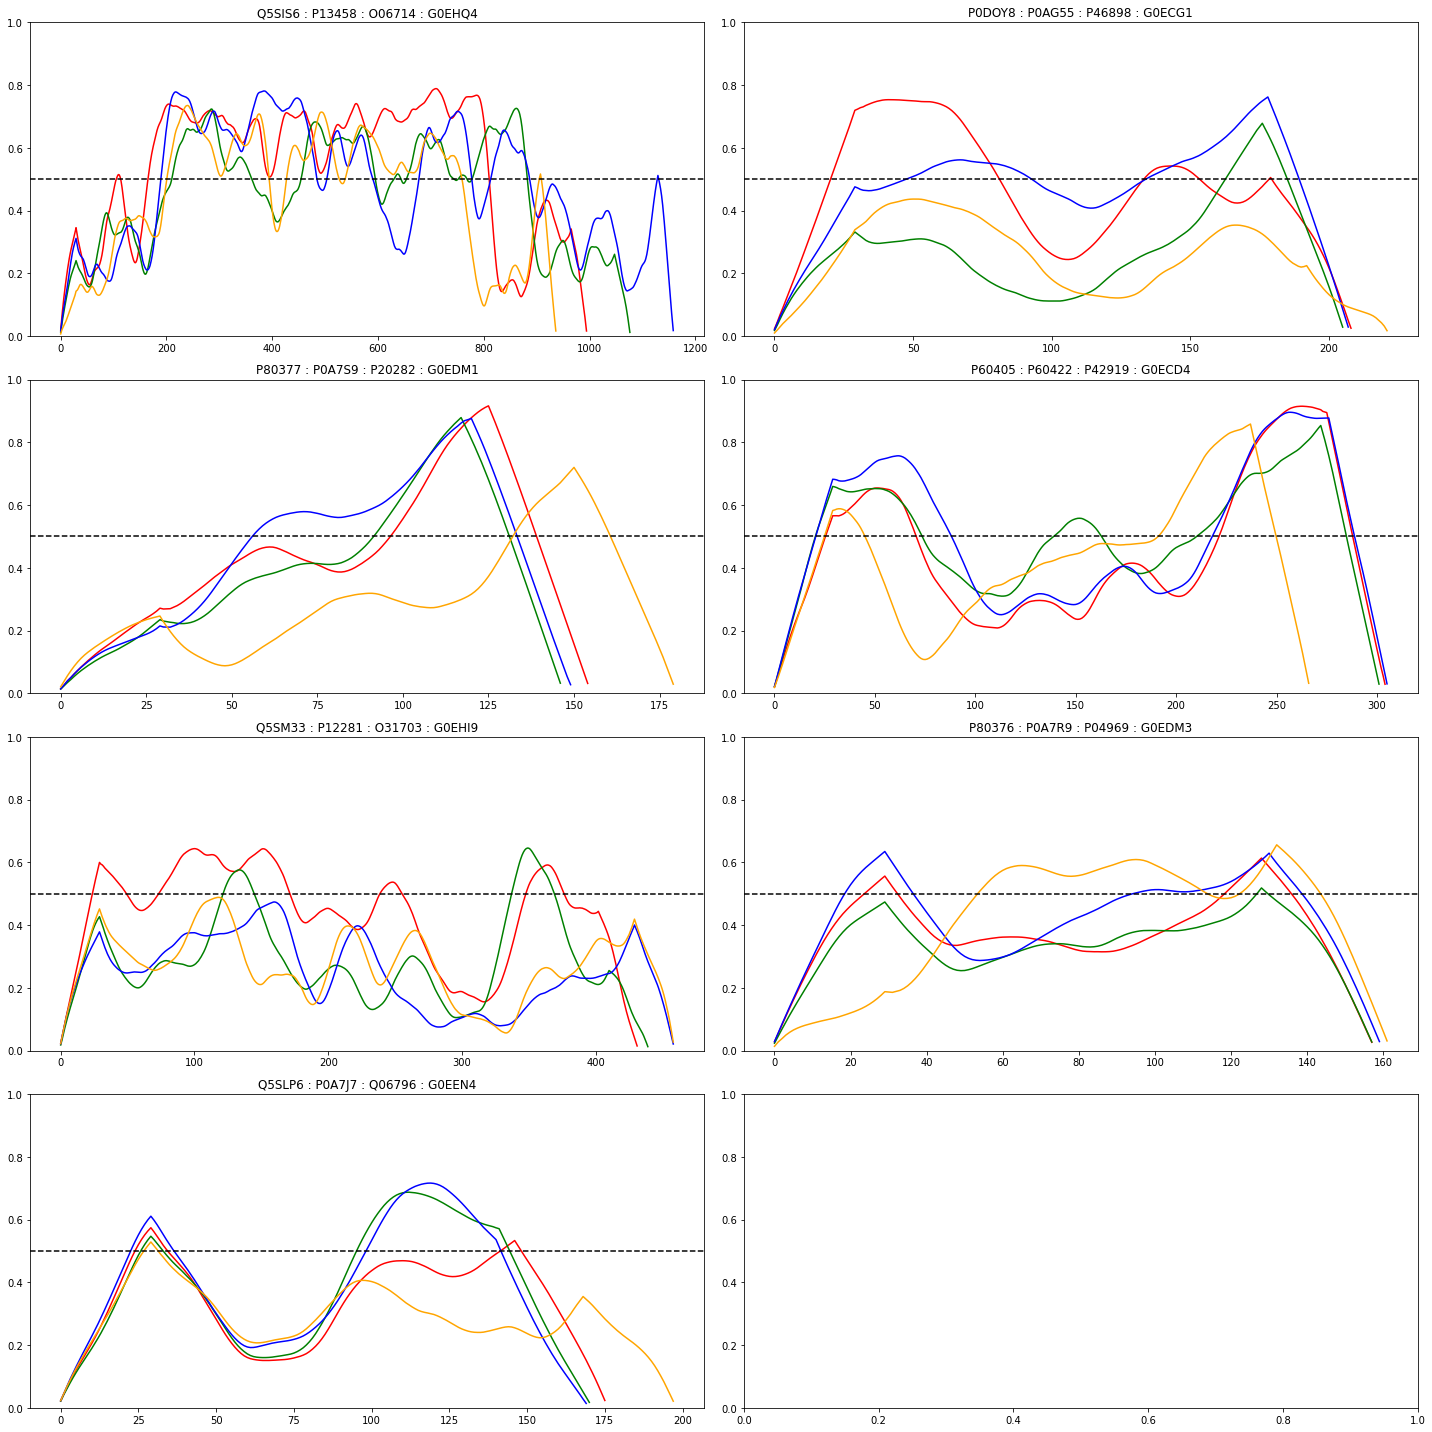

In [264]:
pairs_long = IDP_pairs.query("TT_disorder_binary_mean>=0.5 or EC_disorder_binary_mean>=0.5 or BS_disorder_binary_mean>=0.5 or PF_disorder_binary_mean>=0.5")

n_pairs = len(pairs_long)

conv = 30

fig, axs = plt.subplots(nrows=(n_pairs//2)+1, ncols=2, figsize=(20,20))
for i, ax in enumerate(fig.axes):
  if i < n_pairs:
    title = pairs_long.TT_ID.iloc[i] + ' : ' + pairs_long.EC_ID.iloc[i] + ' : '\
          + pairs_long.BS_ID.iloc[i] + ' : ' + pairs_long.PF_ID.iloc[i]
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.plot(np.convolve(pairs_long.TT_disorder_combined.iloc[i], np.ones(conv)/conv), c='red')
    ax.plot(np.convolve(pairs_long.EC_disorder_combined.iloc[i], np.ones(conv)/conv), c='green')
    ax.plot(np.convolve(pairs_long.BS_disorder_combined.iloc[i], np.ones(conv)/conv), c='blue')
    ax.plot(np.convolve(pairs_long.PF_disorder_combined.iloc[i], np.ones(conv)/conv), c='orange')
    ax.axhline(0.5, ls='--', c='black')

plt.tight_layout()

In [32]:
IDP_pairs.query("TT_disorder_binary_mean>=0.5 or EC_disorder_binary_mean>=0.5 or BS_disorder_binary_mean>=0.5 or PF_disorder_binary_mean>=0.5")[['TT_ID', 'EC_ID', 'BS_ID', 'PF_ID']]

,TT_ID,EC_ID,BS_ID,PF_ID
33,Q5SIS6,P13458,O06714,G0EHQ4
49,P0DOY8,P0AG55,P46898,G0ECG1
67,P80377,P0A7S9,P20282,G0EDM1
76,P60405,P60422,P42919,G0ECD4
86,Q5SM33,P12281,O31703,G0EHI9
88,P80376,P0A7R9,P04969,G0EDM3
90,Q5SLP6,P0A7J7,Q06796,G0EEN4


 29%|██▊       | 2/7 [00:00<00:01,  4.48it/s]

1141 966 1199
1141 1048 1059
1141 1130 1305
1141 908 1001
199 180 186
199 177 199
199 179 198
199 193 213


 57%|█████▋    | 4/7 [00:00<00:00,  6.26it/s]

157 126 132
157 118 157
157 121 157
157 151 182
283 276 321
283 273 283
283 277 284
283 238 244


 86%|████████▌ | 6/7 [00:01<00:00,  6.88it/s]

439 403 412
439 411 420
439 430 466
439 430 458
143 129 139
143 129 143
143 131 145
143 133 145


100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


172 147 150
172 142 167
172 141 171
172 169 200


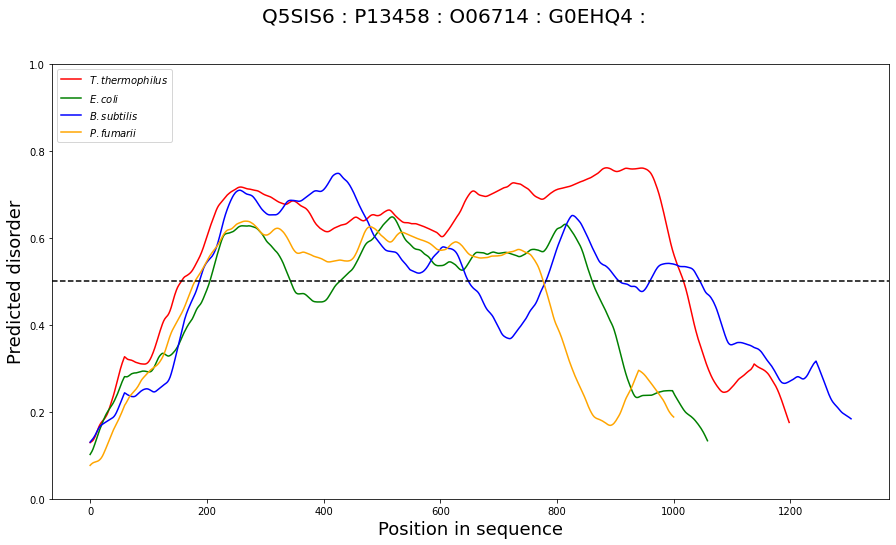

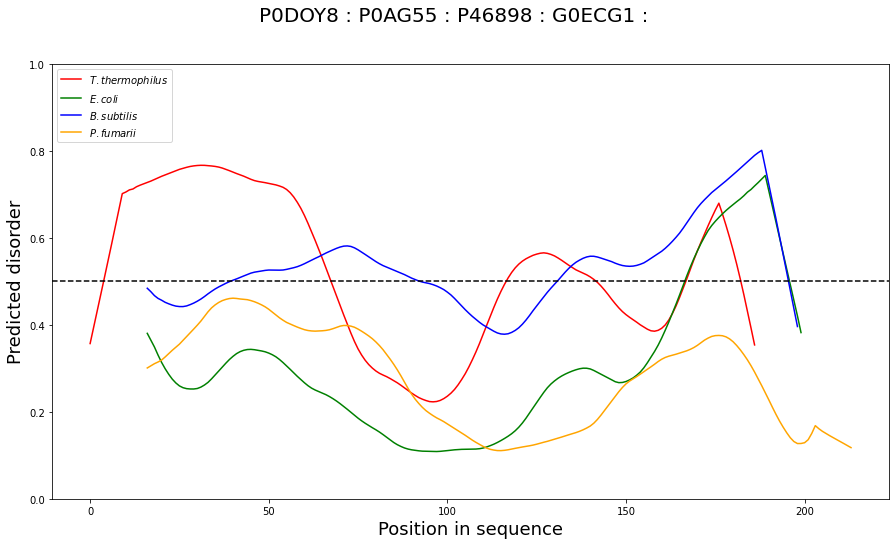

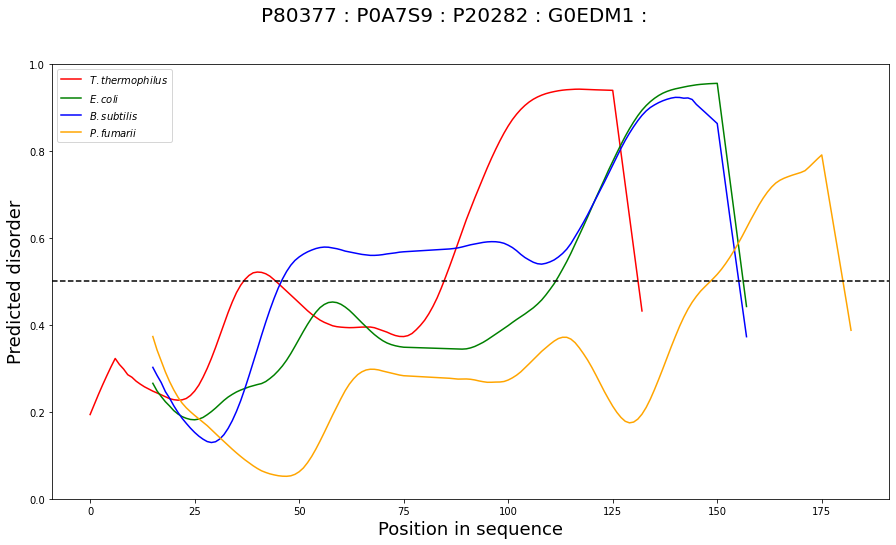

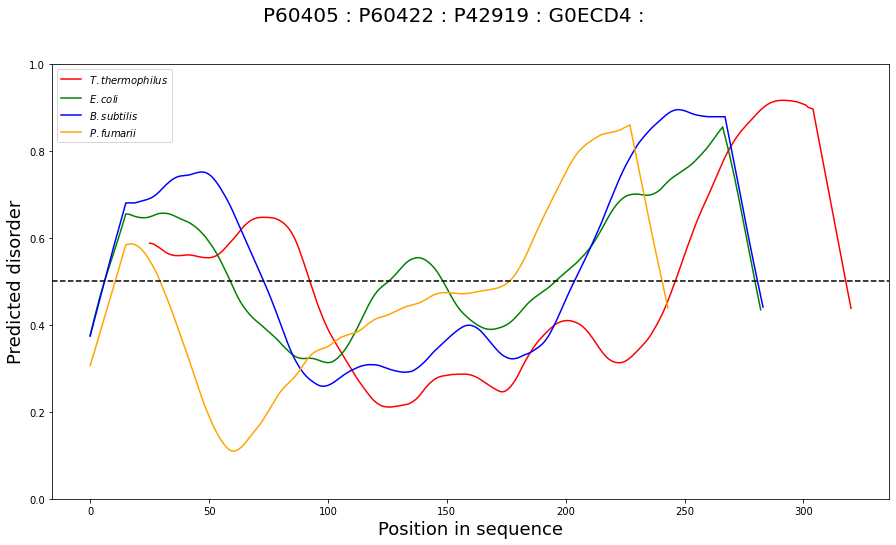

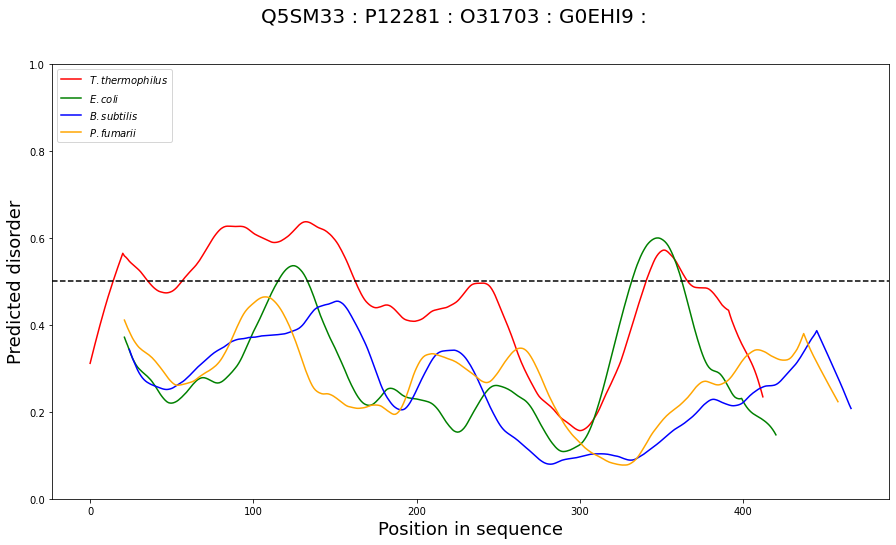

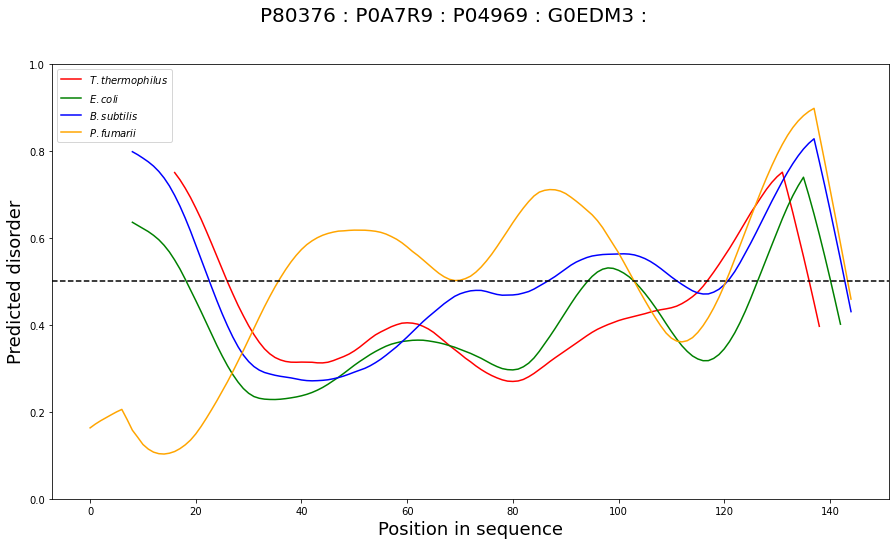

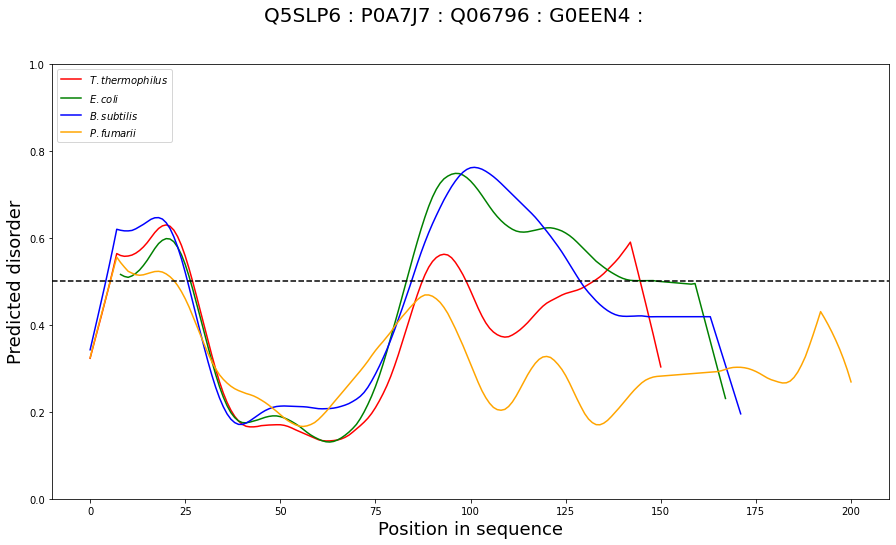

In [304]:
for n in tqdm(IDP_pairs.query('TT_disorder_binary_mean>=0.5 or EC_disorder_binary_mean>=0.5 or BS_disorder_binary_mean>=0.5 or PF_disorder_binary_mean>=0.5')[['TT_ID', 'EC_ID', 'BS_ID', 'PF_ID']].values):
  names = [*n]
  
  fig_name = ''.join([n + '-' for n in names])[:-1] + '.svg'

  labels = ['T. thermophilus', 'E. coli', 'B. subtilis', 'P. fumarii']

  disorder_values = [IDP_pairs.query('TT_ID=="{}"'.format(names[0])).TT_disorder_combined.iloc[0],
                    IDP_pairs.query('EC_ID=="{}"'.format(names[1])).EC_disorder_combined.iloc[0],
                    IDP_pairs.query('BS_ID=="{}"'.format(names[2])).BS_disorder_combined.iloc[0],
                    IDP_pairs.query('PF_ID=="{}"'.format(names[3])).PF_disorder_combined.iloc[0]]
  seqs = [IDP_pairs.query('TT_ID=="{}"'.format(names[0])).TT_Sequence.iloc[0],
          IDP_pairs.query('EC_ID=="{}"'.format(names[1])).EC_Sequence.iloc[0],
          IDP_pairs.query('BS_ID=="{}"'.format(names[2])).BS_Sequence.iloc[0],
          IDP_pairs.query('PF_ID=="{}"'.format(names[3])).PF_Sequence.iloc[0]]
  colors = ['red', 'green', 'blue', 'orange']

  plot_IDR_profile(disorder_values=disorder_values, seqs=seqs, labels=labels, colors=colors, names=names, mav=50, scale_mav=True,
                   gap_ins_pen=-5.0, gap_ext_pen=-0.5, savefig=False)

## Visualisation and statistical analysis



### Whole proteomes

MannwhitneyuResult(statistic=6719112.0, pvalue=6.000888966893344e-139)
MannwhitneyuResult(statistic=6060061.5, pvalue=3.903144305780711e-76)
MannwhitneyuResult(statistic=2744021.5, pvalue=7.11972534246872e-46)
MannwhitneyuResult(statistic=8451692.0, pvalue=1.3394364095899993e-14)
MannwhitneyuResult(statistic=3737977.0, pvalue=1.3165087306561556e-17)
MannwhitneyuResult(statistic=4045387.5, pvalue=0.028470547796333553)


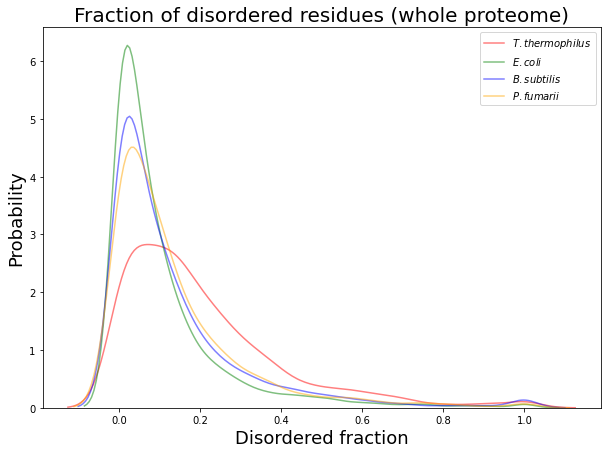

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':TT_proteome.disorder_binary_mean,
                   'EC':EC_proteome.disorder_binary_mean,
                   'BS':BS_proteome.disorder_binary_mean,
                   'PF':PF_proteome.disorder_binary_mean})

sns.kdeplot(df.TT, color='red', alpha=0.5, label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.kdeplot(df.EC, color='green', alpha=0.5, label='$\\it{}$'.format('E. coli'), ax=ax)
sns.kdeplot(df.BS, color='blue', alpha=0.5, label='$\\it{}$'.format('B. subtilis'), ax=ax)
sns.kdeplot(df.PF, color='orange', alpha=0.5, label='$\\it{}$'.format('P. fumarii'), ax=ax)
# sns.histplot(df.TT, color='red', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('T. thermophilus'), ax=ax)
# sns.histplot(df.EC, color='green', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('E. coli'), ax=ax)
# sns.histplot(df.BS, color='blue', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('B. subtilis'), ax=ax)
# sns.histplot(df.PF, color='orange', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('P. fumarii'), ax=ax)
ax.set_title('Fraction of disordered residues (whole proteome)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Disordered fraction', fontsize=18)
ax.legend()

print(mannwhitneyu(df.TT.dropna(), df.EC.dropna()))
print(mannwhitneyu(df.TT.dropna(), df.BS.dropna()))
print(mannwhitneyu(df.TT.dropna(), df.PF.dropna()))
print(mannwhitneyu(df.EC.dropna(), df.BS.dropna()))
print(mannwhitneyu(df.EC.dropna(), df.PF.dropna()))
print(mannwhitneyu(df.BS.dropna(), df.PF.dropna()))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Fraction of disordered residues (whole proteome).svg')

Ttest_indResult(statistic=22.730630776014145, pvalue=3.4192841582410945e-110)
Ttest_indResult(statistic=15.752203368285196, pvalue=6.845393001045072e-55)
Ttest_indResult(statistic=12.041529059130003, pvalue=7.451043912543934e-33)
Ttest_indResult(statistic=-6.966142059504546, pvalue=3.495863805337751e-12)
Ttest_indResult(statistic=-8.216895687606858, pvalue=2.5087816572737993e-16)
Ttest_indResult(statistic=-2.163120934538945, pvalue=0.030569820791106275)


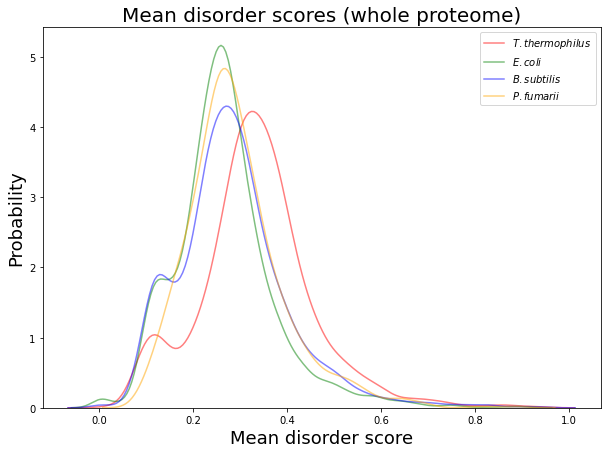

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':TT_proteome.disorder_mean,
                   'EC':EC_proteome.disorder_mean,
                   'BS':BS_proteome.disorder_mean,
                   'PF':PF_proteome.disorder_mean})

sns.kdeplot(df.TT, color='red', alpha=0.5, label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.kdeplot(df.EC, color='green', alpha=0.5, label='$\\it{}$'.format('E. coli'), ax=ax)
sns.kdeplot(df.BS, color='blue', alpha=0.5, label='$\\it{}$'.format('B. subtilis'), ax=ax)
sns.kdeplot(df.PF, color='orange', alpha=0.5, label='$\\it{}$'.format('P. fumarii'), ax=ax)
# sns.histplot(df.TT, color='red', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('T. thermophilus'), ax=ax)
# sns.histplot(df.EC, color='green', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('E. coli'), ax=ax)
# sns.histplot(df.BS, color='yellow', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('B. subtilis'), ax=ax)
ax.set_title('Mean disorder scores (whole proteome)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
print(ttest_ind(df.TT, df.BS, nan_policy='omit'))
print(ttest_ind(df.TT, df.PF, nan_policy='omit'))
print(ttest_ind(df.EC, df.BS, nan_policy='omit'))
print(ttest_ind(df.EC, df.PF, nan_policy='omit'))
print(ttest_ind(df.BS, df.PF, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Mean disorder scores (whole proteome).svg')

WilcoxonResult(statistic=818.0, pvalue=2.048580722776157e-08)
WilcoxonResult(statistic=1205.0, pvalue=4.0643458952560794e-05)
WilcoxonResult(statistic=1241.0, pvalue=2.7003621445585904e-05)
WilcoxonResult(statistic=1691.0, pvalue=0.013640665450305341)
WilcoxonResult(statistic=1985.0, pvalue=0.11853657203500184)
WilcoxonResult(statistic=2283.0, pvalue=0.6135871269893515)


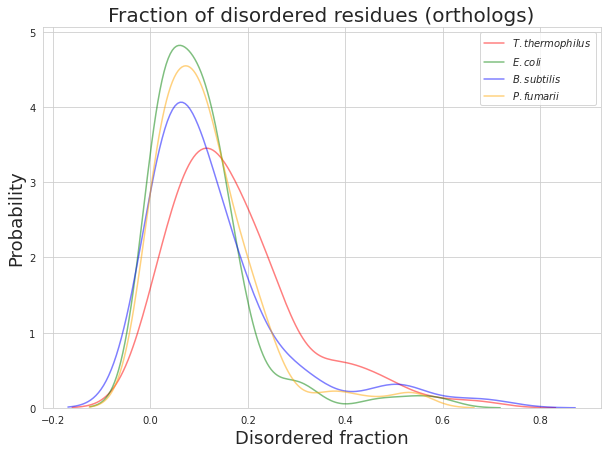

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_binary_mean,
                   'EC':IDP_pairs.EC_disorder_binary_mean,
                   'BS':IDP_pairs.BS_disorder_binary_mean,
                   'PF':IDP_pairs.PF_disorder_binary_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.EC_longest_IDR +\
                              IDP_pairs.BS_longest_IDR + IDP_pairs.PF_longest_IDR) / 4})

sns.kdeplot(df.TT, color='red', alpha=0.5, label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.kdeplot(df.EC, color='green', alpha=0.5, label='$\\it{}$'.format('E. coli'), ax=ax)
sns.kdeplot(df.BS, color='blue', alpha=0.5, label='$\\it{}$'.format('B. subtilis'), ax=ax)
sns.kdeplot(df.PF, color='orange', alpha=0.5, label='$\\it{}$'.format('P. fumarii'), ax=ax)
# sns.histplot(df.TT, color='red', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('T. thermophilus'), ax=ax)
# sns.histplot(df.EC, color='green', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('E. coli'), ax=ax)
# sns.histplot(df.BS, color='blue', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('B. subtilis'), ax=ax)
# sns.histplot(df.PF, color='orange', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('P. fumarii'), ax=ax)
ax.set_title('Fraction of disordered residues (orthologs)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Disordered fraction', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(wilcoxon(df.TT.dropna(), df.EC.dropna()))
print(wilcoxon(df.TT.dropna(), df.BS.dropna()))
print(wilcoxon(df.TT.dropna(), df.PF.dropna()))
print(wilcoxon(df.EC.dropna(), df.BS.dropna()))
print(wilcoxon(df.EC.dropna(), df.PF.dropna()))
print(wilcoxon(df.BS.dropna(), df.PF.dropna()))
# print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Fraction of disordered residues (orthologs).svg')

Ttest_relResult(statistic=8.264913701849895, pvalue=7.318032956538108e-13)
Ttest_relResult(statistic=4.482820508191532, pvalue=2.0195384697690203e-05)
Ttest_relResult(statistic=6.748793171389959, pvalue=1.0911131483654458e-09)
Ttest_relResult(statistic=-3.2943372857109914, pvalue=0.001378067868579693)
Ttest_relResult(statistic=-0.8225161874535066, pvalue=0.4128005669820438)
Ttest_relResult(statistic=2.099506012752676, pvalue=0.038368162049351645)


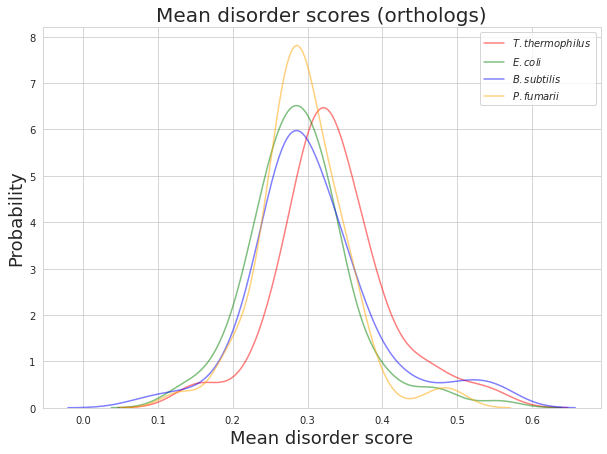

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean,
                   'BS':IDP_pairs.BS_disorder_mean,
                   'PF':IDP_pairs.PF_disorder_mean,})

sns.kdeplot(df.TT, color='red', alpha=0.5, label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.kdeplot(df.EC, color='green', alpha=0.5, label='$\\it{}$'.format('E. coli'), ax=ax)
sns.kdeplot(df.BS, color='blue', alpha=0.5, label='$\\it{}$'.format('B. subtilis'), ax=ax)
sns.kdeplot(df.PF, color='orange', alpha=0.5, label='$\\it{}$'.format('P. fumarii'), ax=ax)
# sns.histplot(df.TT, color='red', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('T. thermophilus'), ax=ax)
# sns.histplot(df.EC, color='green', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('E. coli'), ax=ax)
# sns.histplot(df.BS, color='blue', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('B. subtilis'), ax=ax)
# sns.histplot(df.PF, color='orange', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('P. fumarii'), ax=ax)
ax.set_title('Mean disorder scores (orthologs)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
print(ttest_rel(df.TT, df.EC, nan_policy='omit'))
print(ttest_rel(df.TT, df.BS, nan_policy='omit'))
print(ttest_rel(df.TT, df.PF, nan_policy='omit'))
print(ttest_rel(df.EC, df.BS, nan_policy='omit'))
print(ttest_rel(df.EC, df.PF, nan_policy='omit'))
print(ttest_rel(df.BS, df.PF, nan_policy='omit'))

fig.show()
fig.savefig('Mean disorder scores (orthologs).svg')

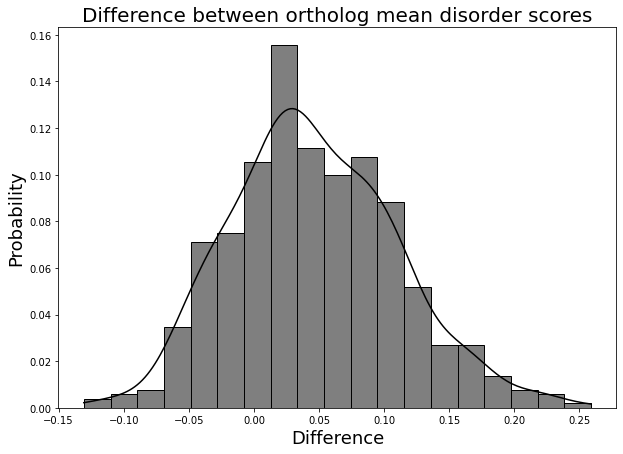

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean})

df['diff'] = df.TT - df.EC

sns.histplot(df['diff'], color='black', kde=True, alpha=0.5, stat='probability', ax=ax)
ax.set_title('Difference between ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Difference', fontsize=18)

fig.show()
fig.savefig('Difference between ortholog mean disorder scores.png')

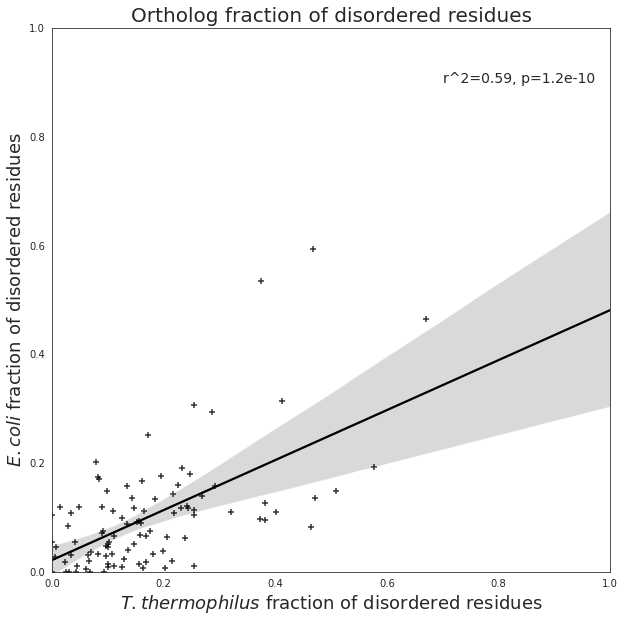

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_binary_mean,
                   'EC':IDP_pairs.EC_disorder_binary_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.EC_longest_IDR) / 2})

ax.set_ylim(0,1)
ax.set_xlim(0,1)
sns.regplot(x=df.TT, y=df.EC, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog fraction of disordered residues', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('E. coli') + ' fraction of disordered residues', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' fraction of disordered residues', fontsize=18)

rsq = pearsonr(df.TT, df.EC)

ax.text(0.7, 0.9, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog fraction of disordered residues.svg')

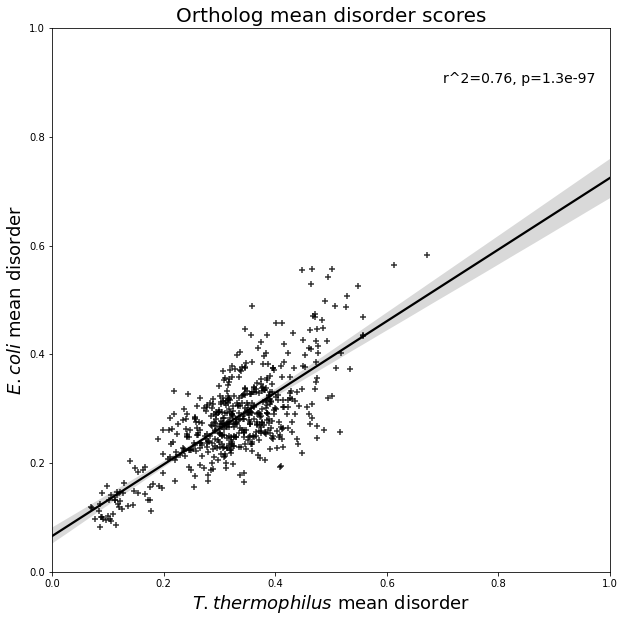

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_mean,
                   'EC':IDP_pairs.EC_disorder_mean,
                   'dis_len':(IDP_pairs.TT_longest_IDR + IDP_pairs.EC_longest_IDR) / 2})

ax.set_ylim(0,1)
ax.set_xlim(0,1)
sns.regplot(x=df.TT, y=df.EC, color='black', truncate=False, marker='+', n_boot=1000)
ax.set_title('Ortholog mean disorder scores', fontsize=20)
ax.set_ylabel('$\\it{}$'.format('E. coli') + ' mean disorder', fontsize=18)
ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' mean disorder', fontsize=18)

rsq = pearsonr(df.TT, df.EC)

ax.text(0.7, 0.9, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

fig.show()
fig.savefig('Ortholog mean disorder scores.png')

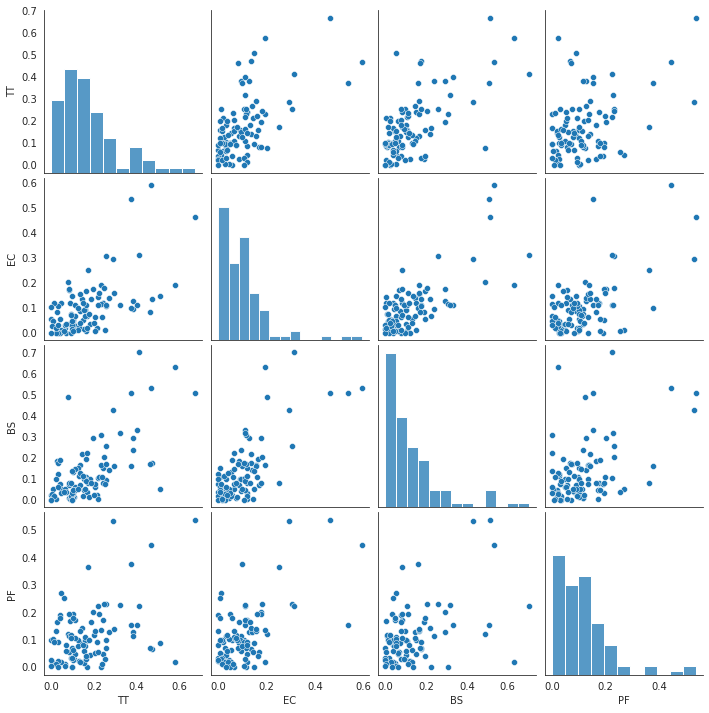

In [ ]:
# fig, ax = plt.subplots(figsize=(10,10))

df = pd.DataFrame({'TT':IDP_pairs.TT_disorder_binary_mean,
                   'EC':IDP_pairs.EC_disorder_binary_mean,
                   'BS':IDP_pairs.BS_disorder_binary_mean,
                   'PF':IDP_pairs.PF_disorder_binary_mean})

sns.pairplot(df)

# ax.set_ylim(0,1)
# ax.set_xlim(0,1)
# sns.regplot(x=df.TT, y=df.EC, color='black', truncate=False, marker='+', n_boot=1000)
# ax.set_title('Ortholog fraction of disordered residues', fontsize=20)
# ax.set_ylabel('$\\it{}$'.format('E. coli') + ' fraction of disordered residues', fontsize=18)
# ax.set_xlabel('$\\it{}$'.format('T. thermophilus') + ' fraction of disordered residues', fontsize=18)

# rsq = pearsonr(df.TT, df.EC)

# ax.text(0.7, 0.9, 'r^2={:.2f}, p={:.2g}'.format(rsq[0], rsq[1]), fontsize=14)

# fig.show()
# fig.savefig('Ortholog fraction of disordered residues.svg')

In [ ]:
for i in ['TT', 'EC', 'BS']:
  for j in ['EC', 'BS', 'PF']:
    if i != j:
      rsq = pearsonr(df[i], df[j])
      print(i, j, round(rsq[0], 3), round(rsq[1], 10), sep=' - ')

TT - EC - 0.594 - 1e-10
TT - BS - 0.653 - 0.0
TT - PF - 0.395 - 5.73536e-05
EC - BS - 0.726 - 0.0
EC - PF - 0.591 - 1e-10
BS - EC - 0.726 - 0.0
BS - PF - 0.445 - 4.3762e-06


### Exclusive to each proteome

In [ ]:
TT_only = TT_proteome[~TT_proteome.ID.isin(IDP_pairs.TT_ID)]
EC_only = EC_proteome[~EC_proteome.ID.isin(IDP_pairs.EC_ID)]

MannwhitneyuResult(statistic=4534307.0, pvalue=5.595543157394245e-112)


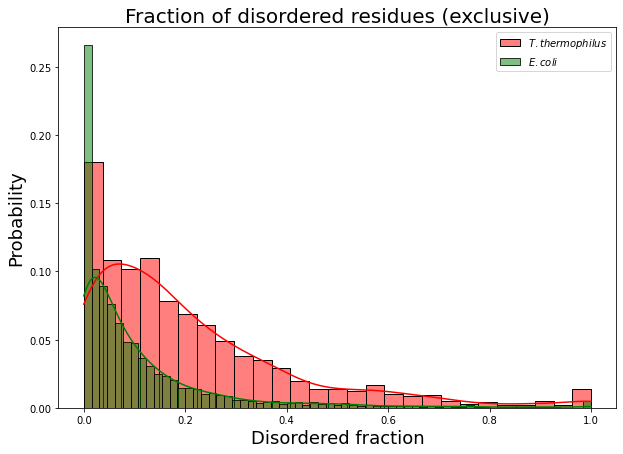

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':TT_only.disorder_binary_mean,
                   'EC':EC_only.disorder_binary_mean})

sns.histplot(df.TT, color='red', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.histplot(df.EC, color='green', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('E. coli'), ax=ax)
ax.set_title('Fraction of disordered residues (exclusive)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Disordered fraction', fontsize=18)
ax.legend()

print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Fraction of disordered residues (exclusive).png')

Ttest_indResult(statistic=20.78824589816085, pvalue=1.6689347328281824e-92)


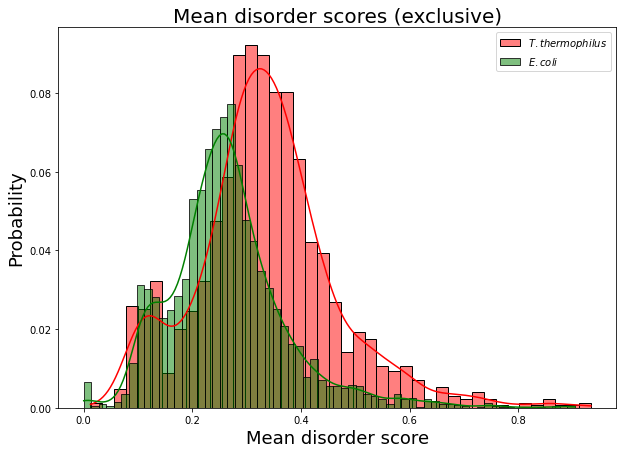

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

df = pd.DataFrame({'TT':TT_only.disorder_mean,
                   'EC':EC_only.disorder_mean})

sns.histplot(df.TT, color='red', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('T. thermophilus'), ax=ax)
sns.histplot(df.EC, color='green', kde=True, alpha=0.5, stat='probability', label='$\\it{}$'.format('E. coli'), ax=ax)
ax.set_title('Mean disorder scores (exclusive)', fontsize=20)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Mean disorder score', fontsize=18)
ax.legend()

# print(mannwhitneyu(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
# print(wilcoxon(df.TT.dropna(), df.EC.dropna(), alternative='greater'))
print(ttest_ind(df.TT, df.EC, nan_policy='omit'))
# print(ttest_rel(df.TT, df.EC, nan_policy='omit'))

fig.show()
fig.savefig('Mean disorder scores (exclusive).png')

### Exclusive to each proteome - most disordered

In [ ]:
n_top = 10

TT_only_top = TT_only.query("longest_IDR>=50").sort_values('disorder_mean', ascending=False).iloc[:n_top]
EC_only_top = EC_only.query("longest_IDR>=50").sort_values('disorder_mean', ascending=False).iloc[:n_top]

In [ ]:
TT_only_top

,ID,Sequence,Length,disorder,disorder_combined,disorder_binary,disorder_mean,disorder_binary_mean,longest_IDR
1728,Q5SKG1,MVRYEPALPLPSYTVRLAPVPVEAVREEAKPQAPIPEARPAEASRP...,383,VLXT VL3 VSL2 iupred3 0 ...,0 0.731157 1 0.704974 2 0.64389...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.728770,0.751958,263
188,Q5SKU1,MPKMKTHKGAKKRVKITASGKVVAMKTGKRHLNWQKSGKEIRQKGR...,65,VLXT VL3 VSL2 iupred3 0 0...,0 0.946002 1 0.943044 2 0.933056 3...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.720541,0.923077,59
1096,Q5SII7,MKNAWQRLKEAWANLPRSTKLLLAALLLVGNVALWYVGLYLPAQVA...,292,VLXT VL3 VSL2 iupred3 0 ...,0 0.513942 1 0.497946 2 0.43485...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.715382,0.787671,185
509,Q5SJ63,MGAVAMTSCPFSRLSPTRMASSASFSRLRLKASTPQVFARKGLPSR...,159,VLXT VL3 VSL2 iupred3 0 ...,0 0.774529 1 0.751124 2 0.75150...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.711813,0.880503,95
1670,Q53WE8,MRKKRKVQSLEEIPKFRSEEEEARFWAEHELDEPLLEAMAPPPEGL...,102,VLXT VL3 VSL2 iupred3 0 ...,0 0.801418 1 0.788319 2 0.78029...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.697207,0.901961,81
1115,Q5SH39,MEEPKITPLARRLAEENGIDWRKLQGTGPDGLIVERDILAYLAKVM...,340,VLXT VL3 VSL2 iupred3 0 ...,0 0.736265 1 0.701624 2 0.70264...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",0.692195,0.694118,163
275,Q5SHQ7,MKLSDLRPNPGANKRRKRVGRGPGSGHGKTATRGHKGQKSRSGGLK...,150,VLXT VL3 VSL2 iupred3 0 ...,0 0.896175 1 0.888506 2 0.90812...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.690112,0.706667,92
1452,Q53W16,MKRKSAYSPSAREKLAFKIPVRRSGQRHYSTSLKRCTPSKCASKRT...,152,VLXT VL3 VSL2 iupred3 0 ...,0 0.875352 1 0.842376 2 0.85797...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.681028,0.782895,69
197,Q7X5K6,MDEKDVATQPQETGQNPRLSGQDEDPGRPEGAEAPPSEGALAPHAR...,163,VLXT VL3 VSL2 iupred3 0 ...,0 0.959345 1 0.952084 2 0.94096...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.665711,0.674847,86
1320,Q5SJG1,MSLDDLLGLLFVLFFIVLPALQGLFRRNPPPDLPFPVEGELEAPPP...,117,VLXT VL3 VSL2 iupred3 0 ...,0 0.535613 1 0.494300 2 0.46535...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.655895,0.641026,73


In [ ]:
EC_only_top

,ID,Sequence,Length,disorder,disorder_combined,disorder_binary,disorder_mean,disorder_binary_mean,longest_IDR
4047,P11557,MDEFKPEDELKPDPSDRRTGRSRQSSERSERTERGEPQINFDDIEL...,428,VLXT VL3 VSL2 iupred3 0 ...,0 0.933892 1 0.946573 2 0.95472...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.752406,0.829439,231
514,P0AEM4,MSIDRTSPLKPVSTVQPRETTDAPVTNSRAAKTTASTSTSVTLSDA...,97,VLXT VL3 VSL2 iupred3 0 0...,0 0.839892 1 0.828722 2 0.845185 3...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.689316,0.865979,71
3815,P29131,MAQRDYVRRSQPAPSRRKKSTSRKKQRNLPAVSPAMVAIAAAVLVT...,319,VLXT VL3 VSL2 iupred3 0 ...,0 0.822267 1 0.803603 2 0.80040...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.682647,0.708464,190
1384,P0A7Q1,MPKIKTVRGAAKRFKKTGKGGFKHKHANLRHILTKKATKRKRHLRP...,65,VLXT VL3 VSL2 iupred3 0 0...,0 0.843519 1 0.824686 2 0.812125 3...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.657112,0.769231,50
4279,P77609,MSVTIQGNTSTVISNNSAPEGTSEIAKITRQIQVLTEKLGKISSEE...,110,VLXT VL3 VSL2 iupred3 0 ...,0 0.663870 1 0.634168 2 0.57032...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.643181,0.918182,59
1265,P52614,MIRLAPLITADVDTTTLPGGKASDAAQDFLALLSEALAGETTTDKA...,375,VLXT VL3 VSL2 iupred3 0 ...,0 0.372377 1 0.340269 2 0.29045...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.639974,0.752000,101
2304,P02929,MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...,239,VLXT VL3 VSL2 iupred3 0 ...,0 0.561418 1 0.559397 2 0.54873...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.633345,0.631799,133
190,P0ACG1,MSVMLQSLNNIRTLRAMAREFSIDVLEEMLEKFRVVTKERREEEEQ...,134,VLXT VL3 VSL2 iupred3 0 ...,0 0.580502 1 0.567176 2 0.52215...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.609643,0.723881,79
1567,P77754,MRKLTALFVASTLALGAANLAHAADTTTAAPADAKPMMHHKGKFGP...,161,VLXT VL3 VSL2 iupred3 0 ...,0 0.434791 1 0.391242 2 0.32782...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.608473,0.788820,99
145,P19934,MSKATEQNDKLKRAIIISAVLHVILFAALIWSSFDENIEASAGGGG...,421,VLXT VL3 VSL2 iupred3 0 ...,0 0.729605 1 0.731195 2 0.71318...,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.605853,0.755344,298


## Charge / hydrophobicity

We use a custom function to calculate mean net charge and mean hydrophobicity for the amino acid sequences. The calcuations are based on [Uversky et.al. 2000 paper](https://doi.org/10.1002/1097-0134(20001115)41:3%3C415::AID-PROT130%3E3.0.CO;2-7)

In [ ]:
for df in [TT_proteome, EC_proteome, BS_proteome, PF_proteome]:
  df['charge_hydrophobicity'] = df.Sequence.apply(get_charge_hydrophobicity)
  df[['mean_net_charge', 'mean_hydrophobicity']] = pd.DataFrame(df['charge_hydrophobicity'].tolist(), index=df.index)
  df['Fraction of disorder'] = df.disorder_binary_mean * 100

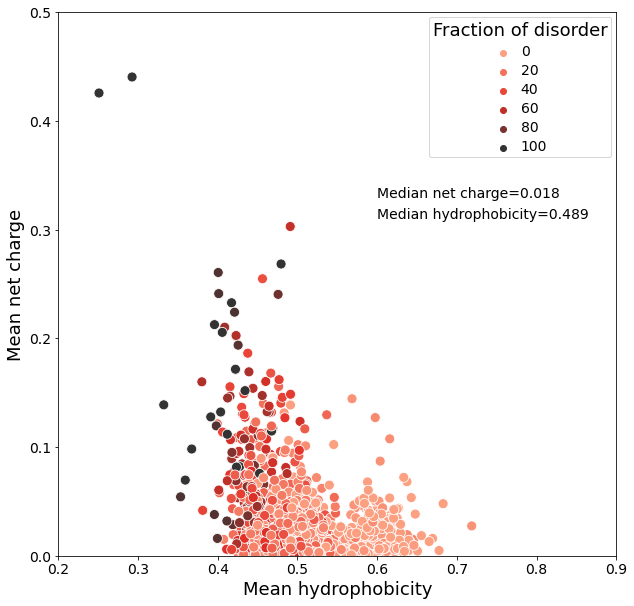

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,10))

ax.set_xlim(0.2, 0.9)
ax.set_ylim(0, 0.5)

ax.set_ylabel('Mean net charge', fontsize=18)
ax.set_xlabel('Mean hydrophobicity', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

sns.scatterplot(data=TT_proteome, x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=100, palette='Reds_d')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='18')

median_charge = TT_proteome.mean_net_charge.median()
median_hydro = TT_proteome.mean_hydrophobicity.median()

ax.text(0.6, 0.33, 'Median net charge={:.3f}'.format(median_charge), fontsize=14)
ax.text(0.6, 0.31, 'Median hydrophobicity={:.3f}'.format(median_hydro), fontsize=14)

fig.savefig('TT_proteome_chplot.svg')

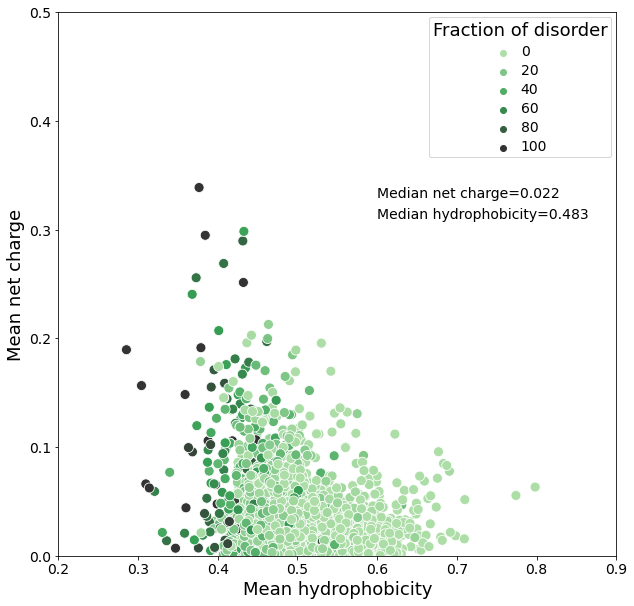

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,10))

ax.set_xlim(0.2, 0.9)
ax.set_ylim(0, 0.5)

ax.set_ylabel('Mean net charge', fontsize=18)
ax.set_xlabel('Mean hydrophobicity', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

sns.scatterplot(data=EC_proteome, x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=100, palette='Greens_d')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='18')

median_charge = EC_proteome.mean_net_charge.median()
median_hydro = EC_proteome.mean_hydrophobicity.median()

ax.text(0.6, 0.33, 'Median net charge={:.3f}'.format(median_charge), fontsize=14)
ax.text(0.6, 0.31, 'Median hydrophobicity={:.3f}'.format(median_hydro), fontsize=14)

fig.savefig('EC_proteome_chplot.svg')

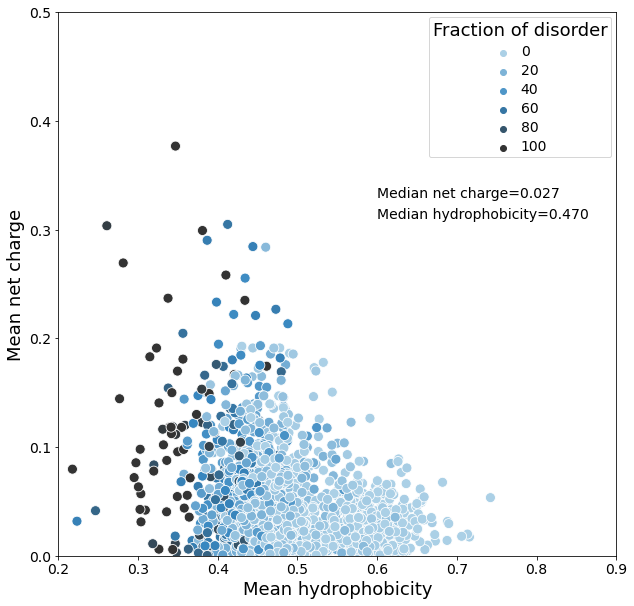

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,10))

ax.set_xlim(0.2, 0.9)
ax.set_ylim(0, 0.5)

ax.set_ylabel('Mean net charge', fontsize=18)
ax.set_xlabel('Mean hydrophobicity', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

sns.scatterplot(data=BS_proteome, x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=100, palette='Blues_d')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='18')

median_charge = BS_proteome.mean_net_charge.median()
median_hydro = BS_proteome.mean_hydrophobicity.median()

ax.text(0.6, 0.33, 'Median net charge={:.3f}'.format(median_charge), fontsize=14)
ax.text(0.6, 0.31, 'Median hydrophobicity={:.3f}'.format(median_hydro), fontsize=14)

fig.savefig('BS_proteome_chplot.svg')

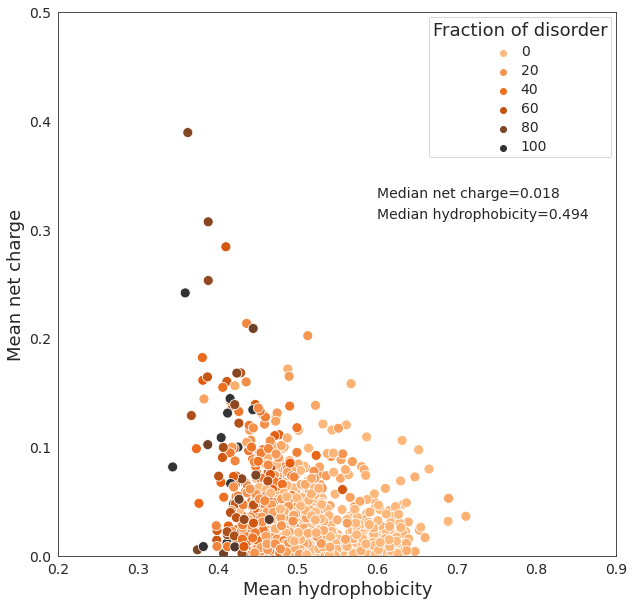

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,10))

ax.set_xlim(0.2, 0.9)
ax.set_ylim(0, 0.5)

ax.set_ylabel('Mean net charge', fontsize=18)
ax.set_xlabel('Mean hydrophobicity', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

sns.scatterplot(data=PF_proteome, x='mean_hydrophobicity', y='mean_net_charge', hue='Fraction of disorder', s=100, palette='Oranges_d')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='18')

median_charge = PF_proteome.mean_net_charge.median()
median_hydro = PF_proteome.mean_hydrophobicity.median()

ax.text(0.6, 0.33, 'Median net charge={:.3f}'.format(median_charge), fontsize=14)
ax.text(0.6, 0.31, 'Median hydrophobicity={:.3f}'.format(median_hydro), fontsize=14)

fig.savefig('PF_proteome_chplot.svg')

In [ ]:
print('T. thermophilus median hydrophobicity: ' + str(TT_proteome.mean_hydrophobicity.median()))
print('T. thermophilus median charge: ' + str(TT_proteome.mean_net_charge.median()))
print('E. coli median hydrophobicity: ' + str(EC_proteome.mean_hydrophobicity.median()))
print('E. coli median charge: ' + str(EC_proteome.mean_net_charge.median()))
print('B. subtilis median hydrophobicity: ' + str(BS_proteome.mean_hydrophobicity.median()))
print('B. subtilis median charge: ' + str(BS_proteome.mean_net_charge.median()))
print('P. fumarii median hydrophobicity: ' + str(PF_proteome.mean_hydrophobicity.median()))
print('P. fumarii median charge: ' + str(PF_proteome.mean_net_charge.median()))

T. thermophilus median hydrophobicity: 0.48915470494417884
T. thermophilus median charge: 0.017627557465854364
E. coli median hydrophobicity: 0.4825268817204295
E. coli median charge: 0.022418123500821743
B. subtilis median hydrophobicity: 0.4701565682281052
B. subtilis median charge: 0.0273383297048034
P. fumarii median hydrophobicity: 0.49399641577060954
P. fumarii median charge: 0.017635226418983223
